Explanations for Detected Anomalies
Transparency:

Model Explanation: The model’s decisions can be made understandable to non-technical stakeholders through clear visualizations and straightforward explanations. For instance, using SHAP values or feature importance scores, we can highlight which features were most influential in detecting each anomaly. By presenting these insights in simple charts or graphs, stakeholders can see how different factors (like sudden spikes or gradual shifts) contributed to the anomaly.
Feature Importance:

Key Features: The most significant features contributing to anomalies include:
Value: The magnitude of deviation from typical values directly impacts anomaly detection.
Rolling Statistics: Metrics like moving averages or standard deviations help identify deviations from expected patterns.
Lag Features: Previous values can show whether recent anomalies are part of a longer trend.
Seasonal and Trend Components: These features help distinguish between regular patterns and unusual deviations.
Explanation Example: For a detected anomaly, the model may show that a sharp increase in the value combined with a deviation from the moving average was crucial in identifying it as a Temporary Spike.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [ ]:

import seaborn as sns
import plotly.express as px

# Enable interactive plots in Colab
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
# Define thresholds for categorizing anomaly types
spike_threshold = 2.0     # Temporary spike: sudden increase
drop_threshold = -2.0     # Sudden drop: sudden decrease
drift_threshold = 0.5     # Gradual drift: slow, consistent change

weight_magnitude = 0.5
weight_duration = 0.2
weight_frequency = 0.2
weight_type = 0.1

In [ ]:
def categorize_anomaly(row):
    if row['anomaly'] == -1:  # If it's an anomaly
        if row['value_change'] > spike_threshold:
            return 'Temporary Spike'
        elif row['value_change'] < drop_threshold:
            return 'Sudden Drop'
        elif abs(row['value_change']) <= drift_threshold:
            return 'Gradual Drift'
    return 'Normal'

In [ ]:
def anomaly(data):
  data['value'].fillna(method='ffill', inplace=True)
  scaler = StandardScaler()
  data['scaled_value'] = scaler.fit_transform(data[['value']])

# Initialize and fit Isolation Forest
  model = IsolationForest(contamination=0.05, random_state=42)
  data['anomaly'] = model.fit_predict(data[['scaled_value']])
  data['value_change'] = data['value'].diff()
  data['anomaly_type'] = data.apply(categorize_anomaly, axis=1)
  median_value = data[data['anomaly'] == 1]['value'].median()

  def calculate_severity(row, window_size=10):
    if row['anomaly'] == -1:  # Only compute for anomalies
        # Magnitude Severity
        magnitude_severity = np.abs((row['value'] - median_value) / median_value) * 100

        # Duration Severity (number of consecutive anomalies)
        duration_severity = 1  # Assuming 1 anomaly for now;

        # Frequency Severity (count how many anomalies occurred within a given window)
        start_window = row.name - pd.DateOffset(days=window_size)
        end_window = row.name + pd.DateOffset(days=window_size)
        recent_anomalies = data.loc[start_window:end_window, 'anomaly'] == -1
        frequency_severity = recent_anomalies.sum()

        # Type Severity
        if row['anomaly_type'] == 'Temporary Spike':
            type_severity = 5
        elif row['anomaly_type'] == 'Gradual Drift':
            type_severity = 3
        elif row['anomaly_type'] == 'Sudden Drop':
            type_severity = 7
        else:
            type_severity = 0

        # Final Score based on weighted sum
        score = (weight_magnitude * magnitude_severity +
                 weight_duration * duration_severity +
                 weight_frequency * frequency_severity +
                 weight_type * type_severity)

        return score
    return 0


  data['severity_score'] = data.apply(calculate_severity, axis=1)
  data['severity_score'] = data['severity_score'].replace([np.inf, -np.inf], np.nan)
  max_severity = data['severity_score'].max()
  data['severity_score'] = data['severity_score'].fillna(max_severity + 10)


# Flag anomalies (-1 means anomaly, 1 means normal)
  anomalies = data[data['anomaly'] == -1].sort_values(by='severity_score', ascending=False)

# Print or visualize anomalies

  return anomalies

In [ ]:
for i in range(1,18):
  data = pd.read_csv("/content/drive/MyDrive/computing-usage-dataset/"+str(i)+".csv", parse_dates=['timestamp'], index_col='timestamp')
  data = anomaly(data)
  print(i,data)

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-106-92af0c62b712>:16: RuntimeWarning:

divide by zero encountered in scalar divide



1                            value  scaled_value  anomaly  value_change  \
timestamp                                                               
2014-04-02 15:00:00   19949200.0      0.032853       -1    19949200.0   
2014-04-11 10:40:00  658440000.0      8.045361       -1   630943600.0   
2014-04-11 00:25:00  528632000.0      6.416382       -1   372536000.0   
2014-04-11 01:55:00  340659000.0      4.057484       -1   310717200.0   
2014-04-11 02:00:00  339663000.0      4.044985       -1     -996000.0   
...                          ...           ...      ...           ...   
2014-04-08 19:45:00   17594000.0      0.003297       -1    17594000.0   
2014-04-08 19:55:00  448469000.0      5.410406       -1   413203300.0   
2014-04-08 21:35:00   20055700.0      0.034189       -1    20055700.0   
2014-04-08 21:45:00  428189000.0      5.155909       -1   377172500.0   
2014-04-16 06:30:00   76687800.0      0.744873       -1   -22623000.0   

                        anomaly_type  severity_s

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



2                      value  scaled_value  anomaly  value_change  \
timestamp                                                         
2014-04-15 03:19:00  1.602     17.782085       -1         1.536   
2014-04-08 03:29:00  1.534     16.983973       -1         1.468   
2014-04-11 03:34:00  1.490     16.467547       -1         1.424   
2014-04-06 03:44:00  1.468     16.209334       -1         1.334   
2014-04-12 03:04:00  1.466     16.185860       -1         1.398   
...                    ...           ...      ...           ...   
2014-04-03 12:49:00  0.136      0.575716       -1         0.070   
2014-04-15 21:04:00  0.136      0.575716       -1         0.070   
2014-04-03 02:04:00  0.136      0.575716       -1         0.070   
2014-04-16 04:59:00  0.136      0.575716       -1         0.070   
2014-04-16 05:19:00  0.136      0.575716       -1         0.068   

                      anomaly_type  severity_score  
timestamp                                           
2014-04-15 03:19:00 

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



3                       value  scaled_value  anomaly  value_change  \
timestamp                                                          
2014-02-22 00:02:00  99.668      7.949810       -1        24.422   
2014-02-28 05:12:00  91.002      7.216039       -1        77.268   
2014-02-27 22:57:00  82.890      6.529177       -1        50.952   
2014-02-27 21:22:00  79.724      6.261104       -1        35.094   
2014-02-28 01:32:00  79.084      6.206913       -1        35.984   
...                     ...           ...      ...           ...   
2014-02-18 02:02:00  10.948      0.437675       -1         6.382   
2014-02-17 11:32:00  11.100      0.450545       -1         0.878   
2014-02-26 06:22:00  10.908      0.434288       -1       -44.576   
2014-02-27 16:22:00  11.050      0.446311       -1       -31.692   
2014-02-14 20:12:00  11.058      0.446989       -1       -44.678   

                        anomaly_type  severity_score  
timestamp                                             
201

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



4                          value  scaled_value  anomaly  value_change  \
timestamp                                                             
2014-03-12 21:01:00  8285420.0     10.529034       -1     7843908.0   
2014-03-17 21:01:00  8164340.0     10.372930       -1     8140076.8   
2014-03-17 08:41:00  8125060.0     10.322288       -1     8104363.2   
2014-03-17 20:01:00  8111350.0     10.304612       -1     8090396.5   
2014-03-16 00:16:00  7369120.0      9.347682       -1     6786173.0   
...                        ...           ...      ...           ...   
2014-03-12 21:36:00    90486.2     -0.036394       -1       63948.2   
2014-03-17 01:31:00    85797.5     -0.042439       -1     -185311.5   
2014-03-17 00:21:00    80307.5     -0.049517       -1      -80314.5   
2014-03-06 21:41:00    79453.6     -0.050618       -1      -96809.4   
2014-03-10 21:06:00    76659.0     -0.054221       -1       68496.6   

                        anomaly_type  severity_score  
timestamp          

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



5                        value  scaled_value  anomaly  value_change  \
timestamp                                                           
2014-01-29 04:15:00   0.6560     -2.056453       -1       0.31800   
2014-01-29 01:00:00   0.6660     -2.055692       -1      -0.34000   
2014-01-29 08:40:00   0.4225     -2.074218       -1       0.42250   
2014-01-29 00:50:00   0.9960     -2.030584       -1      -0.33800   
2014-01-29 05:55:00   0.6660     -2.055692       -1       0.66600   
...                      ...           ...      ...           ...   
2014-01-17 01:50:00  37.8887      0.776359       -1       0.22470   
2014-01-17 02:20:00  37.6687      0.759621       -1       4.33540   
2014-01-17 01:45:00  37.6640      0.759263       -1       3.54000   
2014-01-17 01:55:00  37.6533      0.758449       -1      -0.23540   
2014-01-16 18:45:00  28.8093      0.085562       -1      19.71839   

                        anomaly_type  severity_score  
timestamp                                    

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



6                      value  scaled_value  anomaly  value_change  \
timestamp                                                         
2014-04-22 19:34:00  656.0     10.486892       -1         481.0   
2014-04-12 17:59:00  381.0      5.633181       -1          98.0   
2014-04-12 17:34:00  381.0      5.633181       -1         219.0   
2014-04-16 20:54:00  369.0      5.421383       -1         107.0   
2014-04-22 19:49:00  338.0      4.874237       -1         143.0   
...                    ...           ...      ...           ...   
2014-04-12 05:54:00    1.0     -1.073765       -1        -170.0   
2014-04-22 04:24:00    1.0     -1.073765       -1         -33.0   
2014-04-22 07:34:00    1.0     -1.073765       -1         -23.0   
2014-04-10 12:24:00    1.0     -1.073765       -1         -67.0   
2014-04-10 10:04:00    1.0     -1.073765       -1          -8.0   

                        anomaly_type  severity_score  
timestamp                                             
2014-04-22 19:34

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



7                        value  scaled_value  anomaly  value_change  \
timestamp                                                           
2014-04-16 04:04:00  18.7225     -5.884535       -1       -5.8195   
2014-04-16 14:14:00  24.0820     -5.440765       -1      -12.0840   
2014-04-16 03:34:00  24.4320     -5.411785       -1      -34.0300   
2014-04-16 10:14:00  24.4840     -5.407479       -1      -12.1420   
2014-04-16 12:14:00  24.6260     -5.395722       -1      -11.2280   
...                      ...           ...      ...           ...   
2014-04-11 04:54:00  97.3740      0.627855       -1        4.5820   
2014-04-11 04:59:00  97.3740      0.627855       -1        0.0000   
2014-04-11 05:34:00  97.5840      0.645243       -1        1.5000   
2014-04-23 23:09:00  99.0400      0.765801       -1        5.9640   
2014-04-23 20:09:00  97.4160      0.631333       -1        4.5820   

                        anomaly_type  severity_score  
timestamp                                    

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



8                       value  scaled_value  anomaly  value_change  \
timestamp                                                          
2014-04-11 05:05:00  99.898      3.319549       -1        10.388   
2014-04-11 14:25:00  99.834      3.317172       -1         1.764   
2014-04-16 03:55:00  99.834      3.317172       -1         7.700   
2014-04-09 21:55:00  99.800      3.315909       -1         6.200   
2014-04-10 18:45:00  99.770      3.314795       -1         0.460   
...                     ...           ...      ...           ...   
2014-04-14 21:25:00   3.502     -0.260579       -1         3.402   
2014-04-14 05:55:00   3.488     -0.261099       -1       -20.360   
2014-04-11 09:35:00   3.434     -0.263105       -1       -36.854   
2014-04-09 17:05:00   3.184     -0.272390       -1       -63.126   
2014-04-08 19:20:00   3.094     -0.275732       -1         2.860   

                        anomaly_type  severity_score  
timestamp                                             
201

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



9                           value  scaled_value  anomaly  value_change  \
timestamp                                                              
2013-10-09 16:35:00  61519397.0     12.554928       -1    10773819.0   
2013-10-09 16:40:00  55996401.0     11.336374       -1    -5522996.0   
2013-10-09 16:30:00  50745578.0     10.177870       -1    40819024.0   
2013-10-10 09:35:00  46141497.6      9.162059       -1     4527213.0   
2013-10-10 09:30:00  41614284.6      8.163207       -1     1896408.6   
...                         ...           ...      ...           ...   
2013-10-09 20:25:00  10097324.2      1.209532       -1      824189.0   
2013-10-09 16:25:00   9926554.0      1.171854       -1           NaN   
2013-10-10 04:45:00    789781.0     -0.844018       -1     -154318.2   
2013-10-10 06:35:00    792172.0     -0.843490       -1     -236761.8   
2013-10-10 05:10:00    800122.2     -0.841736       -1     -204177.2   

                        anomaly_type  severity_score  
timest

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-106-92af0c62b712>:16: RuntimeWarning:

divide by zero encountered in scalar divide



10                            value  scaled_value  anomaly  value_change  \
timestamp                                                               
2014-03-03 17:14:00   20765900.0      0.351259       -1    20765900.0   
2014-03-13 00:29:00   36532200.0      0.741694       -1  -178237800.0   
2014-03-12 20:04:00   46952400.0      0.999738       -1    46952400.0   
2014-03-12 20:09:00  451674000.0     11.022211       -1   404721600.0   
2014-03-12 20:59:00   49577200.0      1.064738       -1    47044230.0   
...                          ...           ...      ...           ...   
2014-03-07 22:04:00   30258800.0      0.586340       -1  -136112200.0   
2014-03-07 22:49:00  149547000.0      3.540378       -1   129484000.0   
2014-03-07 22:54:00   44137700.0      0.930035       -1  -105409300.0   
2014-03-07 22:59:00   30758500.0      0.598715       -1   -13379200.0   
2014-03-18 00:24:00    6516740.0     -0.001605       -1   -90652660.0   

                        anomaly_type  severity_

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



11                        value  scaled_value  anomaly  value_change  \
timestamp                                                           
2014-02-24 21:57:00  68.0920      5.805589       -1       22.2000   
2014-02-19 00:22:00  62.0560      4.402857       -1        7.4527   
2014-02-18 19:57:00  55.8460      2.959688       -1       15.2860   
2014-02-17 18:57:00  56.4080      3.090293       -1       16.2300   
2014-02-19 00:17:00  54.6033      2.670891       -1        4.5883   
...                      ...           ...      ...           ...   
2014-02-28 09:32:00  36.5960     -1.513903       -1       -2.0420   
2014-02-28 07:22:00  36.7920     -1.468354       -1       -1.3780   
2014-02-28 07:32:00  36.8820     -1.447438       -1       -1.7340   
2014-02-28 12:17:00  36.5680     -1.520410       -1       -2.4040   
2014-02-28 13:27:00  36.7140     -1.486481       -1       -1.9940   

                        anomaly_type  severity_score  
timestamp                                   

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



12                            value  scaled_value  anomaly  value_change  \
timestamp                                                               
2014-04-15 17:09:00  245126000.0     53.080841       -1   244790890.0   
2014-04-15 16:54:00  138797000.0     30.002072       -1   132193910.0   
2014-04-15 17:14:00   63229300.0     13.600060       -1  -181896700.0   
2014-04-15 16:44:00   13429000.0      2.790877       -1    13164041.0   
2014-04-15 21:19:00   10957300.0      2.254393       -1    10716104.0   
...                          ...           ...      ...           ...   
2014-04-16 04:29:00     101699.0     -0.101821       -1      -19219.0   
2014-04-16 04:44:00     107019.0     -0.100666       -1      -22884.0   
2014-04-16 04:34:00     117616.0     -0.098366       -1       15917.0   
2014-04-16 04:24:00     120918.0     -0.097649       -1       25626.0   
2014-04-16 04:39:00     129903.0     -0.095699       -1       12287.0   

                        anomaly_type  severity_

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



13                      value  scaled_value  anomaly  value_change  \
timestamp                                                         
2014-02-20 03:10:00  2.656      8.146701       -1         0.850   
2014-02-23 03:10:00  2.650      8.087555       -1         0.758   
2014-02-22 03:10:00  2.638      7.969265       -1         0.838   
2014-02-24 03:40:00  2.600      7.594679       -1         0.894   
2014-02-25 03:40:00  2.576      7.358099       -1         0.748   
...                    ...           ...      ...           ...   
2014-02-15 02:25:00  1.670     -1.572818       -1        -0.094   
2014-02-28 05:25:00  1.670     -1.572818       -1        -0.190   
2014-02-28 10:35:00  1.670     -1.572818       -1        -0.230   
2014-02-14 21:35:00  1.670     -1.572818       -1        -0.118   
2014-02-28 04:25:00  1.694     -1.336237       -1        -0.138   

                      anomaly_type  severity_score  
timestamp                                           
2014-02-20 03:10:00

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



14                        value  scaled_value  anomaly  value_change  \
timestamp                                                           
2014-02-25 07:15:00  25.1033      4.652449       -1       19.0673   
2014-02-27 00:50:00  19.1650      3.026441       -1        2.4700   
2014-02-25 07:55:00  18.3333      2.798708       -1        2.9133   
2014-02-25 07:20:00  17.1860      2.484558       -1       -7.9173   
2014-02-26 11:30:00  17.2200      2.493868       -1        3.3333   
...                      ...           ...      ...           ...   
2014-02-15 02:05:00   7.3340     -0.213087       -1        1.0680   
2014-02-14 21:20:00   7.2660     -0.231706       -1        1.6440   
2014-02-14 18:30:00   7.2700     -0.230611       -1        1.4060   
2014-02-15 08:15:00   5.2280     -0.789745       -1       -1.4220   
2014-02-14 22:50:00   5.3980     -0.743196       -1       -1.0820   

                        anomaly_type  severity_score  
timestamp                                   

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



15                        value  scaled_value  anomaly  value_change  \
timestamp                                                           
2014-04-15 05:24:00  99.6700      2.677422       -1        0.1860   
2014-04-16 09:44:00  99.6940      2.678517       -1        0.4940   
2014-04-15 11:44:00  99.6720      2.677513       -1        0.3300   
2014-04-15 12:54:00  99.6720      2.677513       -1        0.4460   
2014-04-15 09:44:00  99.6720      2.677513       -1        0.2360   
...                      ...           ...      ...           ...   
2014-04-15 00:04:00  55.3940      0.657388       -1        2.7815   
2014-04-03 05:24:00  45.4380      0.203158       -1        0.3240   
2014-04-04 01:29:00  25.2580     -0.717528       -1      -12.5760   
2014-04-05 08:29:00  27.6760     -0.607210       -1      -11.2200   
2014-04-14 23:44:00  52.6125      0.530486       -1       20.8525   

                        anomaly_type  severity_score  
timestamp                                   

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



16                      value  scaled_value  anomaly  value_change  \
timestamp                                                         
2014-02-26 22:05:00  2.344     23.393159       -1         2.212   
2014-02-21 03:25:00  1.600     15.545148       -1         1.532   
2014-02-20 03:35:00  1.598     15.524051       -1         1.462   
2014-02-28 03:20:00  1.600     15.545148       -1         1.466   
2014-02-18 03:20:00  1.534     14.848953       -1         1.400   
...                    ...           ...      ...           ...   
2014-02-14 20:20:00  0.200      0.777385       -1         0.066   
2014-02-14 19:35:00  0.200      0.777385       -1         0.066   
2014-02-18 23:55:00  0.138      0.123384       -1         0.072   
2014-02-17 23:55:00  0.140      0.144481       -1         0.008   
2014-02-27 23:55:00  0.138      0.123384       -1         0.004   

                        anomaly_type  severity_score  
timestamp                                             
2014-02-26 22:0

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



17                        value  scaled_value  anomaly  value_change  \
timestamp                                                           
2014-04-13 06:52:00  76.2300     10.223065       -1       62.5240   
2014-04-13 06:57:00  65.8350      8.368305       -1      -10.3950   
2014-04-20 07:57:00  32.5000      2.420402       -1        5.4325   
2014-04-19 21:07:00  31.5225      2.245988       -1        4.0225   
2014-04-21 23:12:00  31.7125      2.279890       -1        2.5425   
...                      ...           ...      ...           ...   
2014-04-10 02:27:00  15.0380     -0.695311       -1        0.7340   
2014-04-10 01:07:00  15.0000     -0.702091       -1        1.6680   
2014-04-10 00:27:00  15.0020     -0.701734       -1        0.6700   
2014-04-10 00:57:00  15.0460     -0.693884       -1        1.7120   
2014-04-10 00:12:00  15.0000     -0.702091       -1        1.6660   

                        anomaly_type  severity_score  
timestamp                                   

<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-106-92af0c62b712>:16: RuntimeWarning:

divide by zero encountered in scalar divide



1


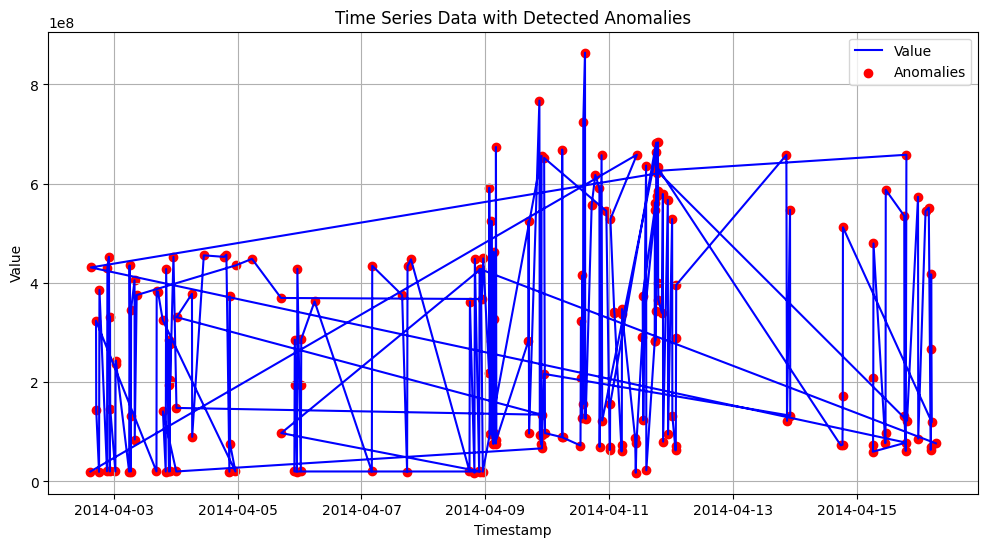

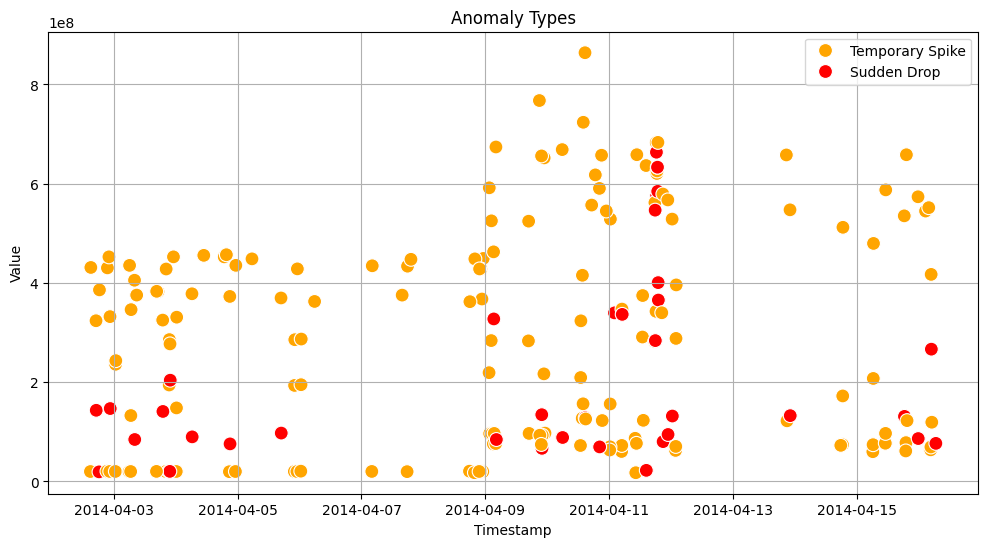

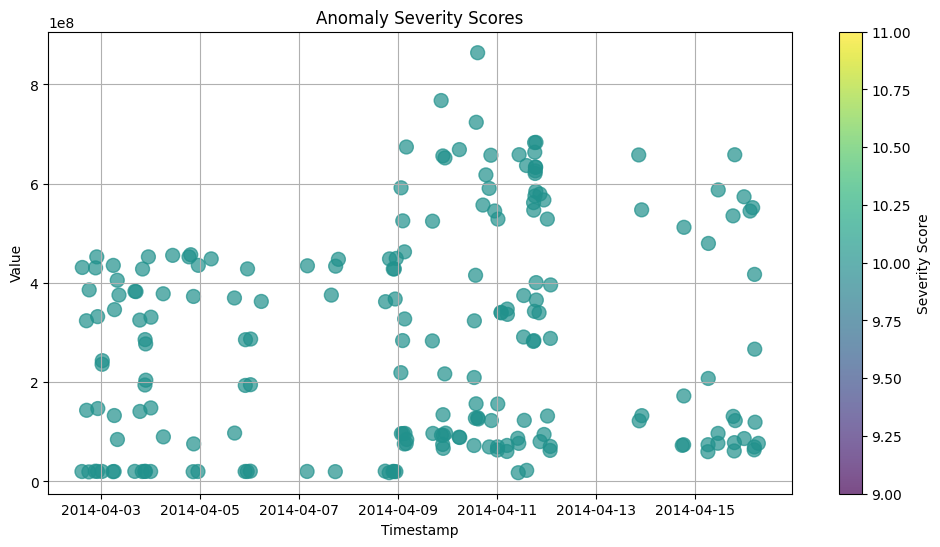

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



2


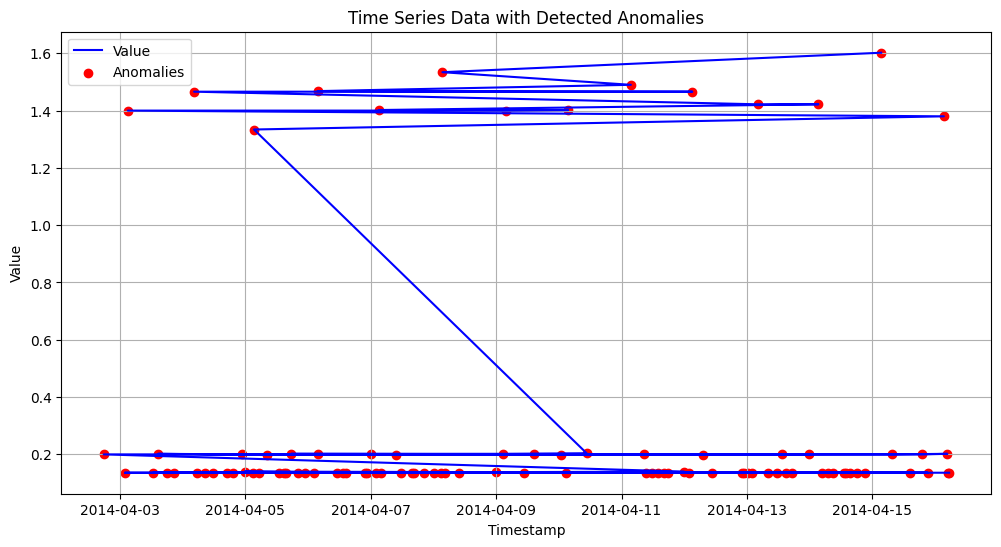

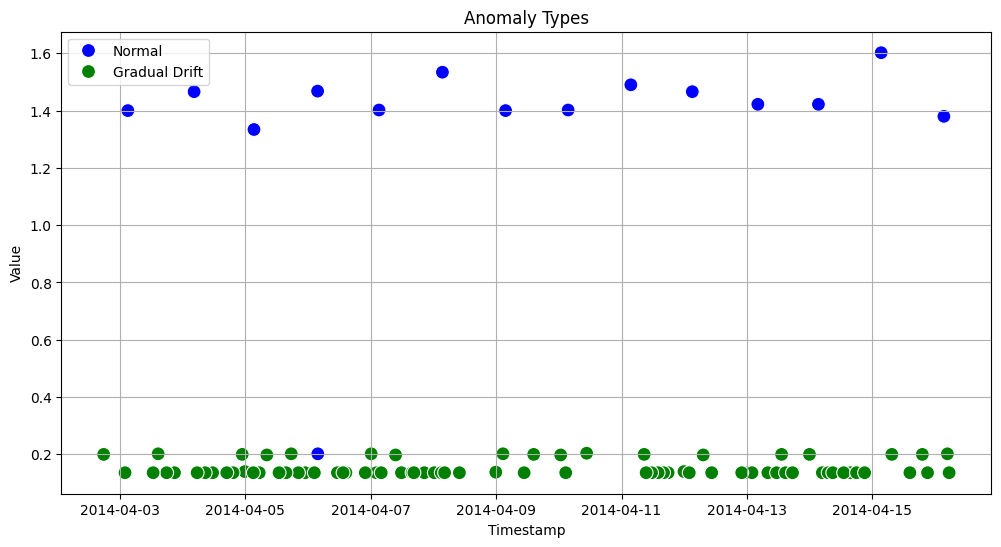

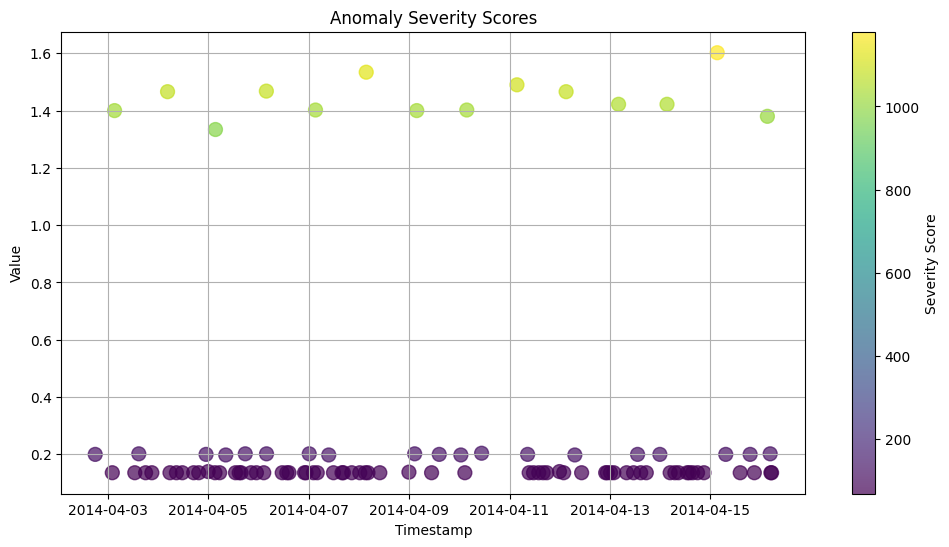

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



3


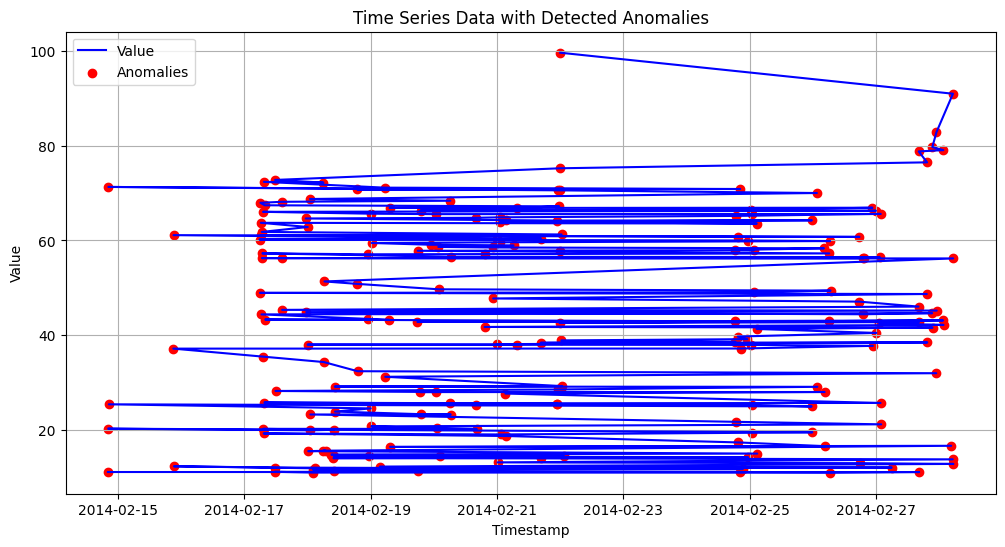

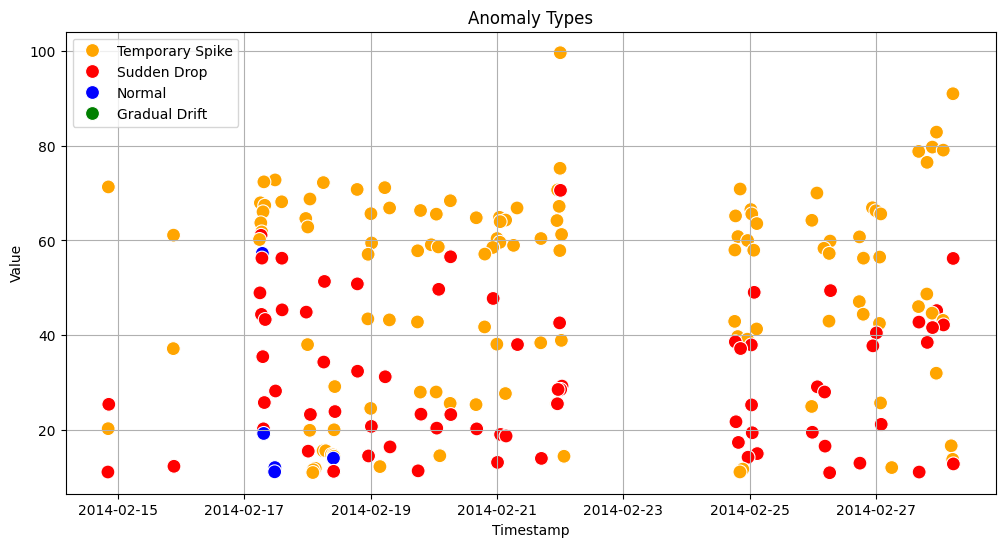

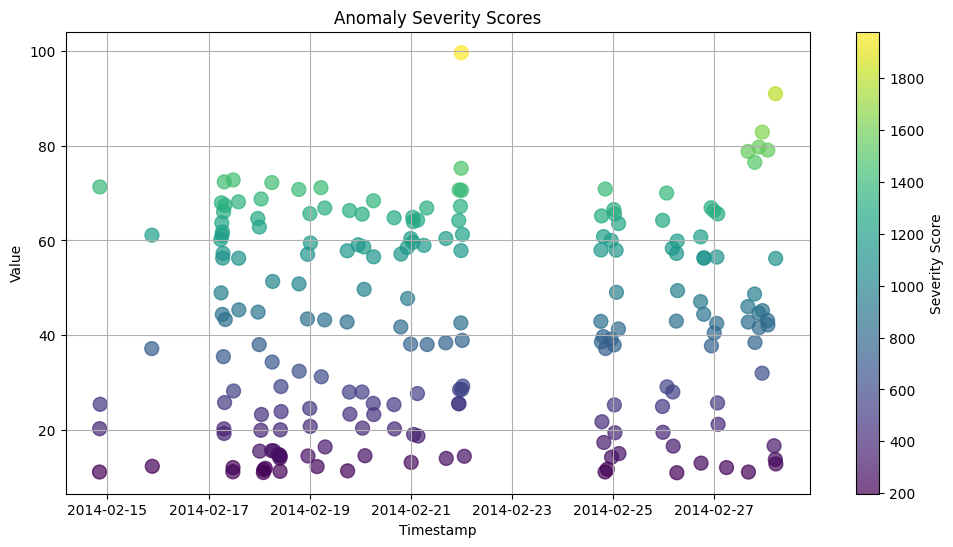

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



4


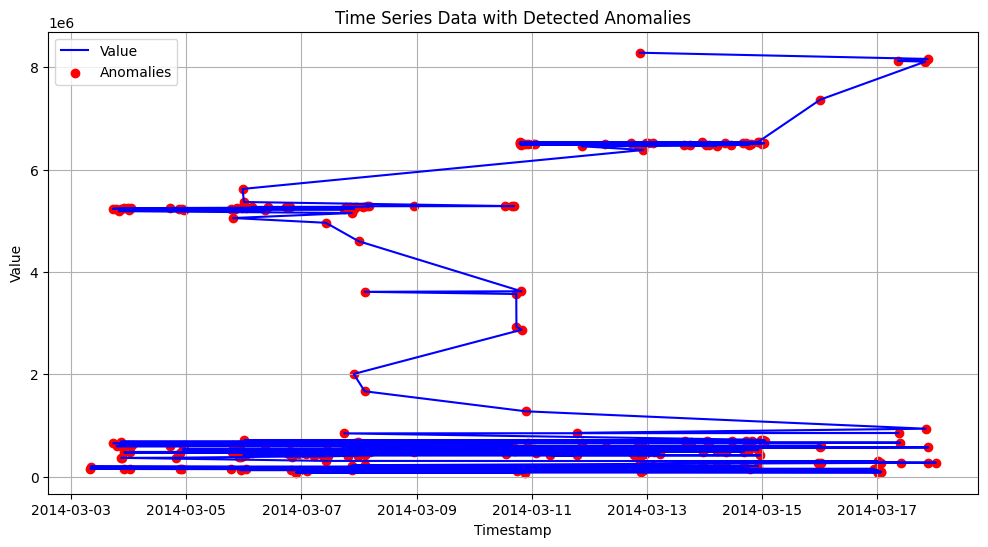

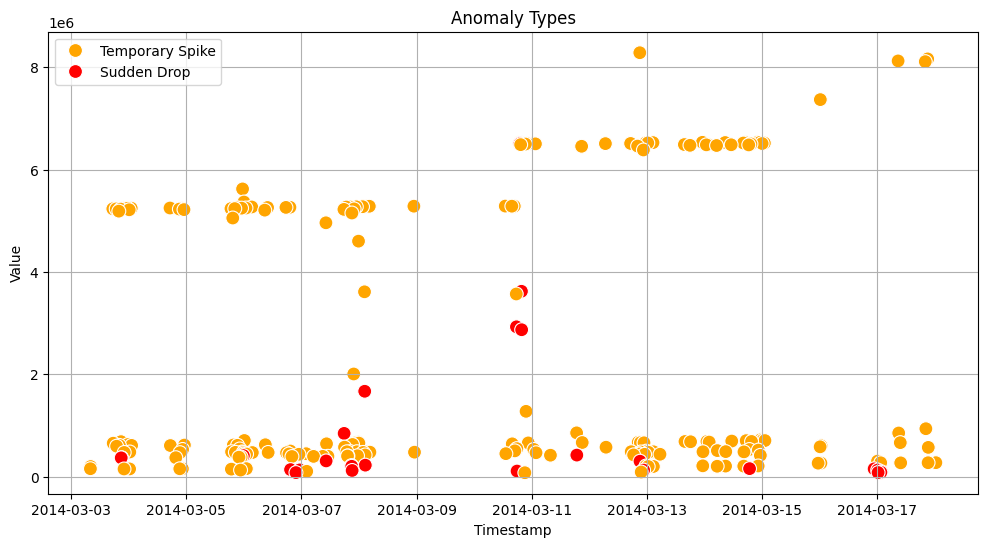

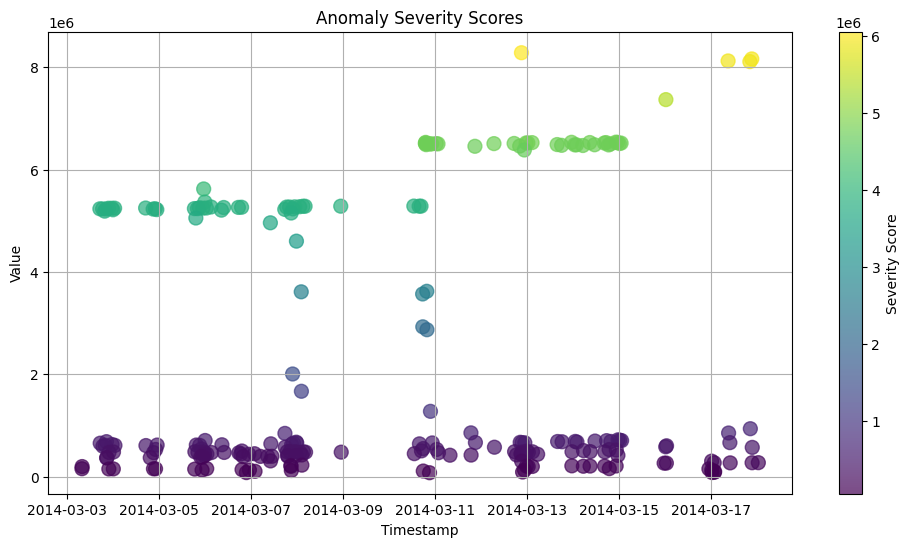

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



5


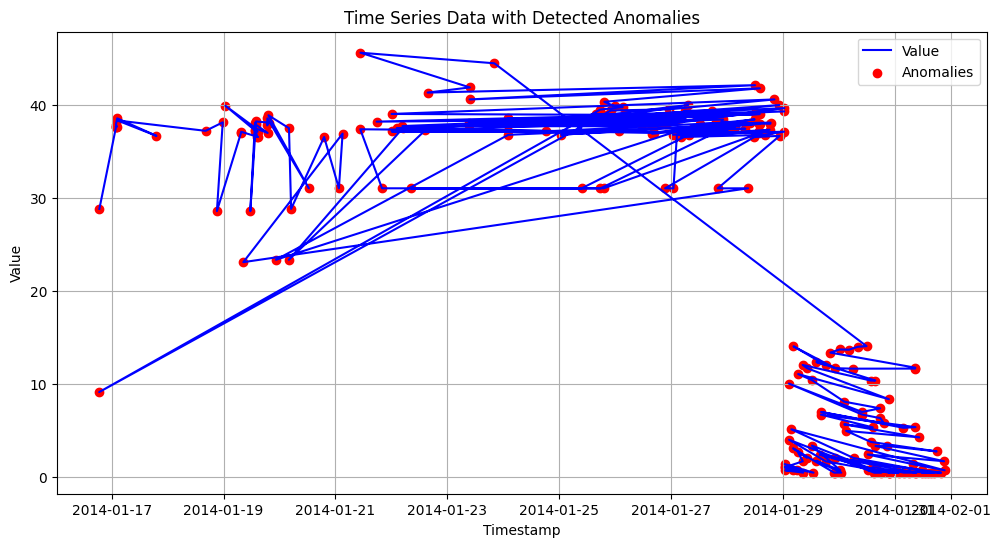

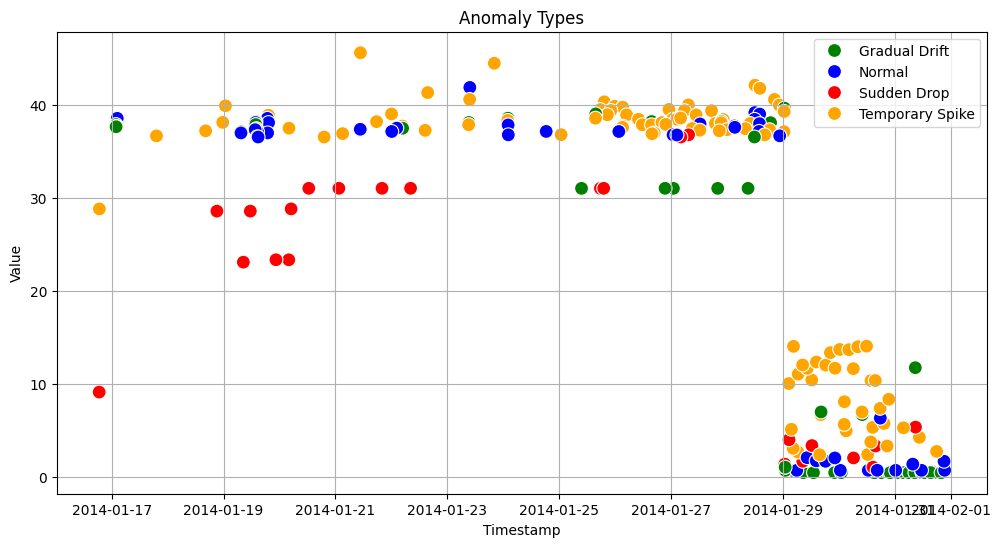

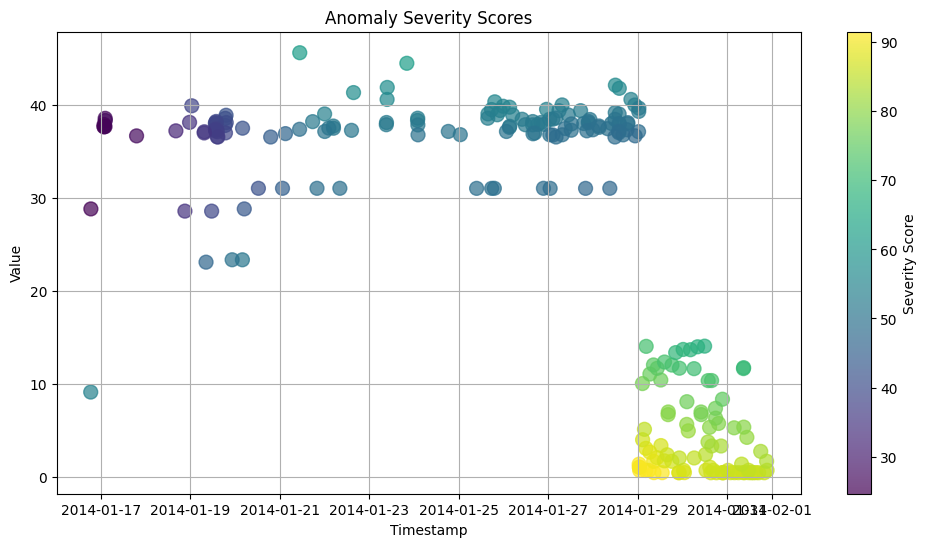

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



6


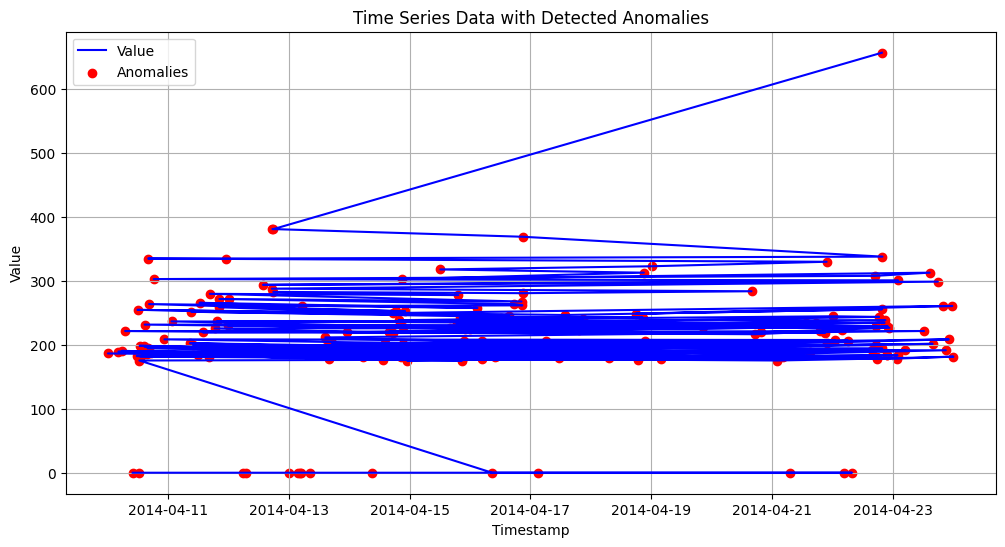

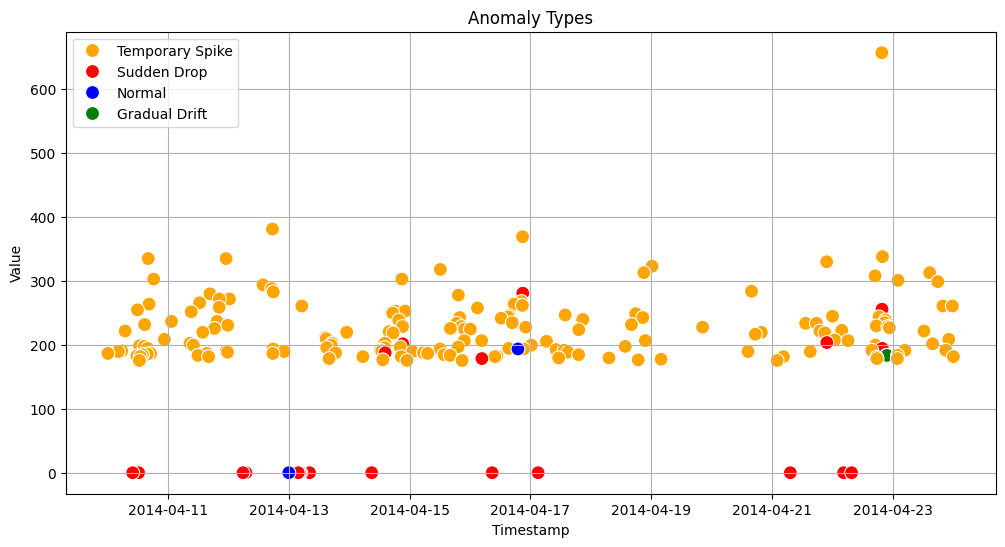

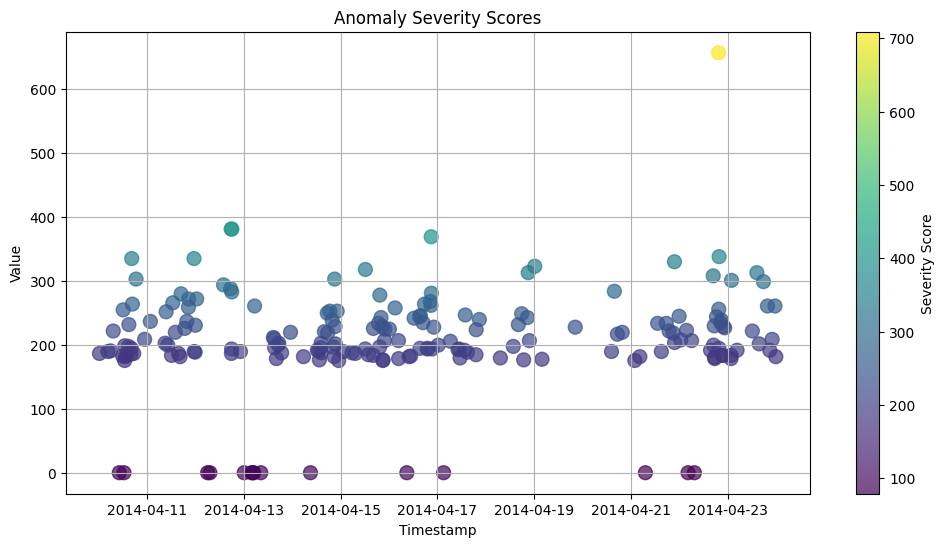

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



7


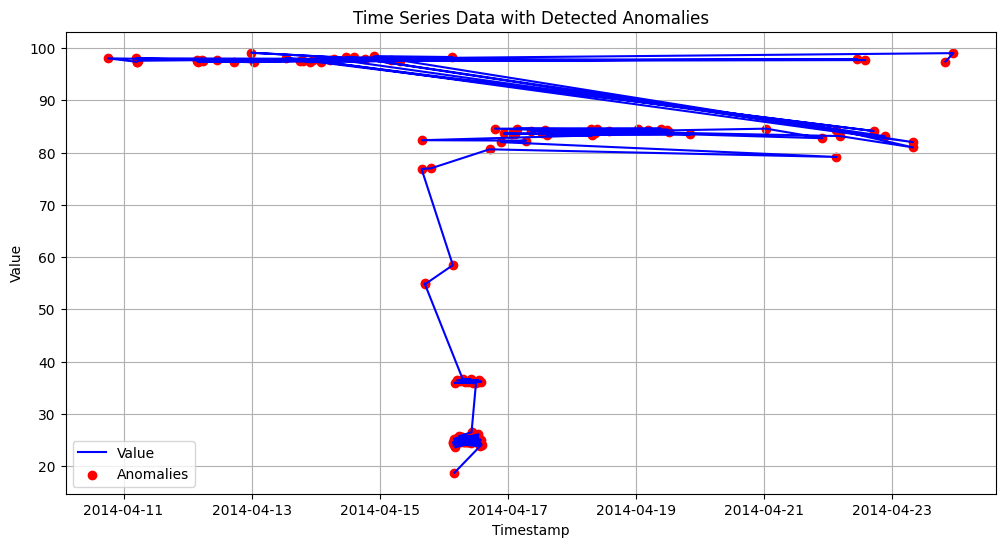

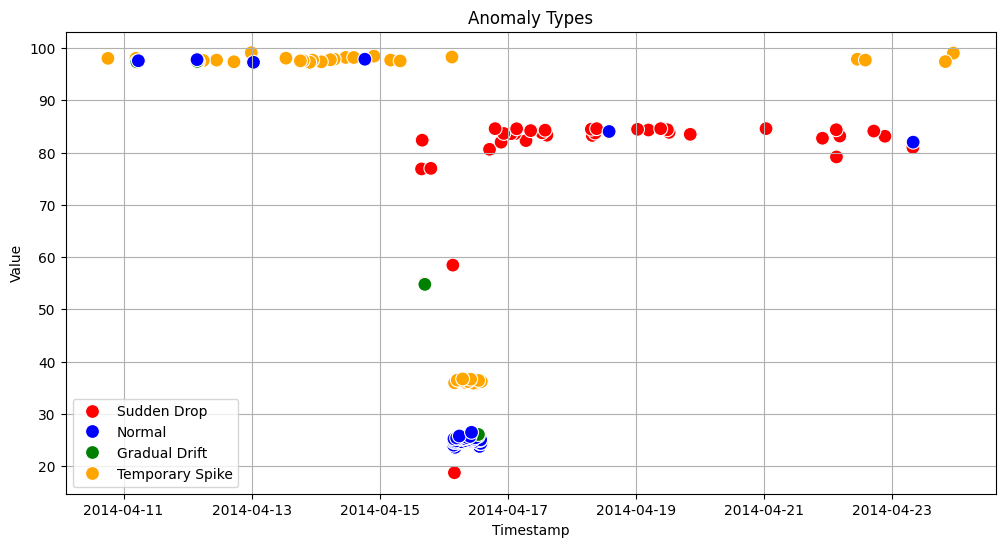

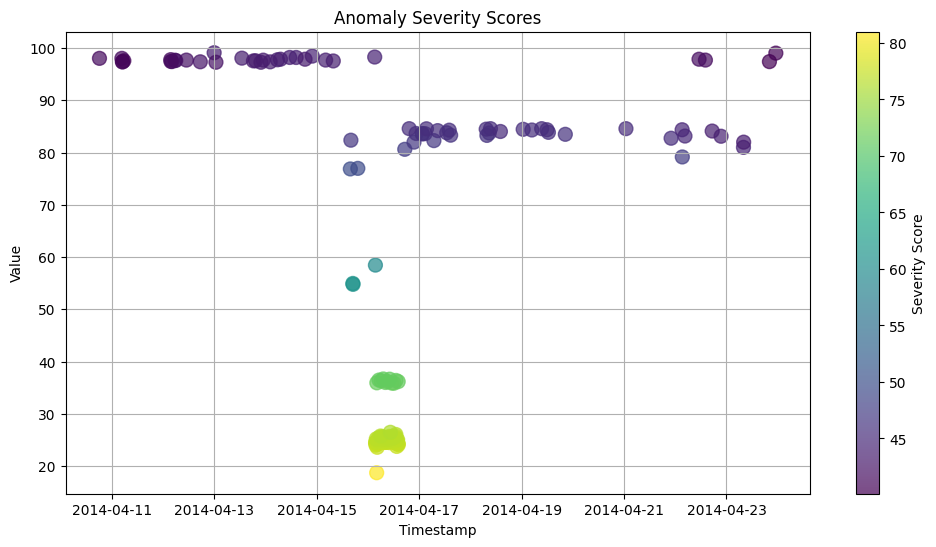

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



8


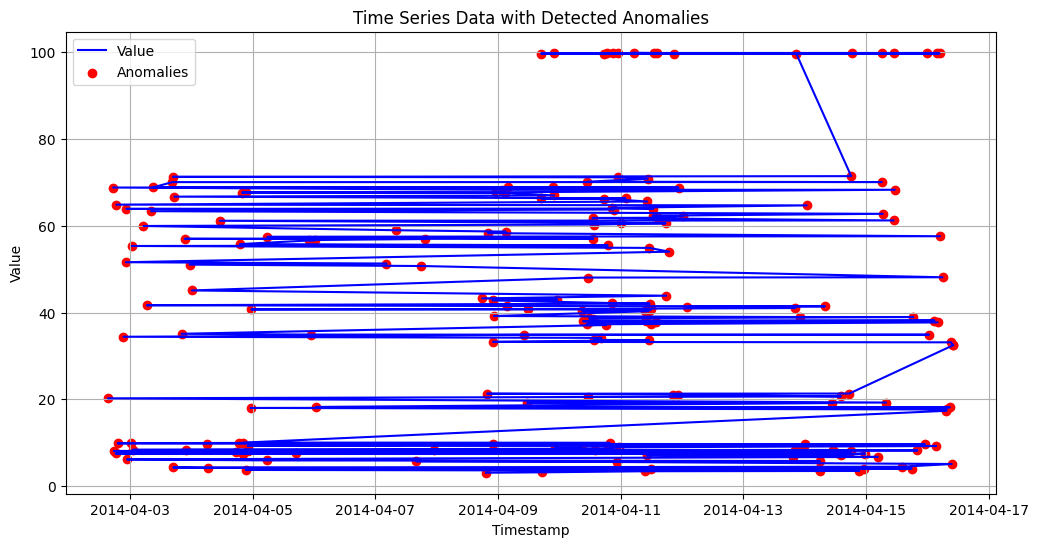

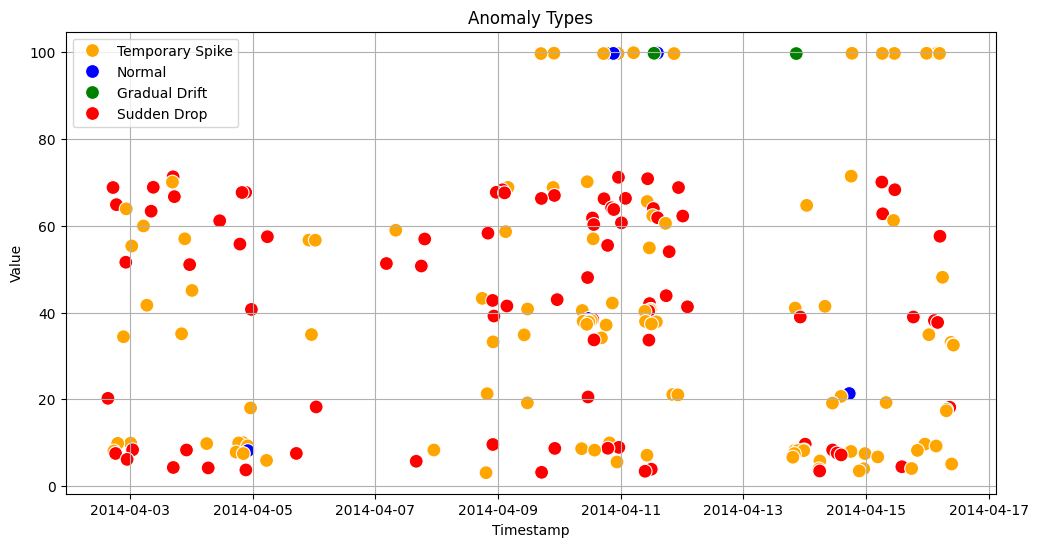

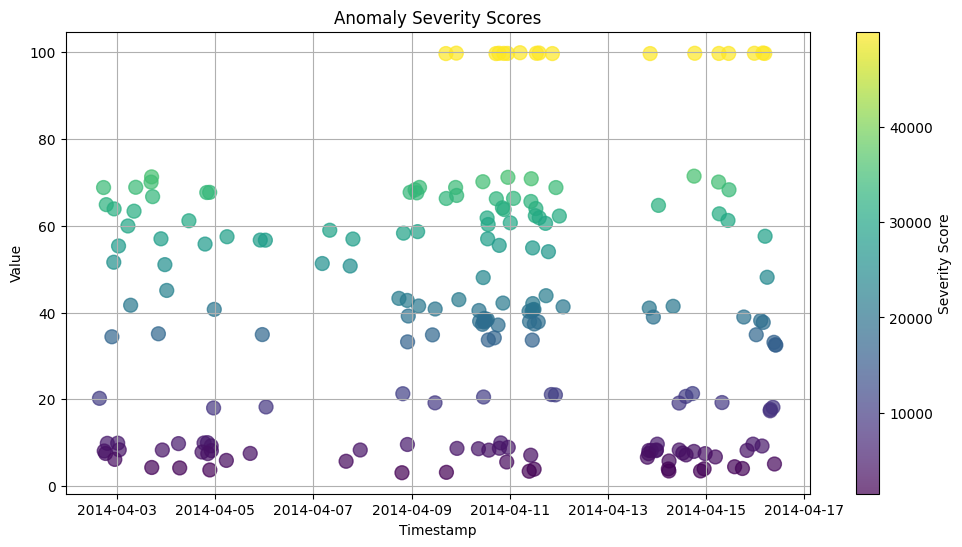

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



9


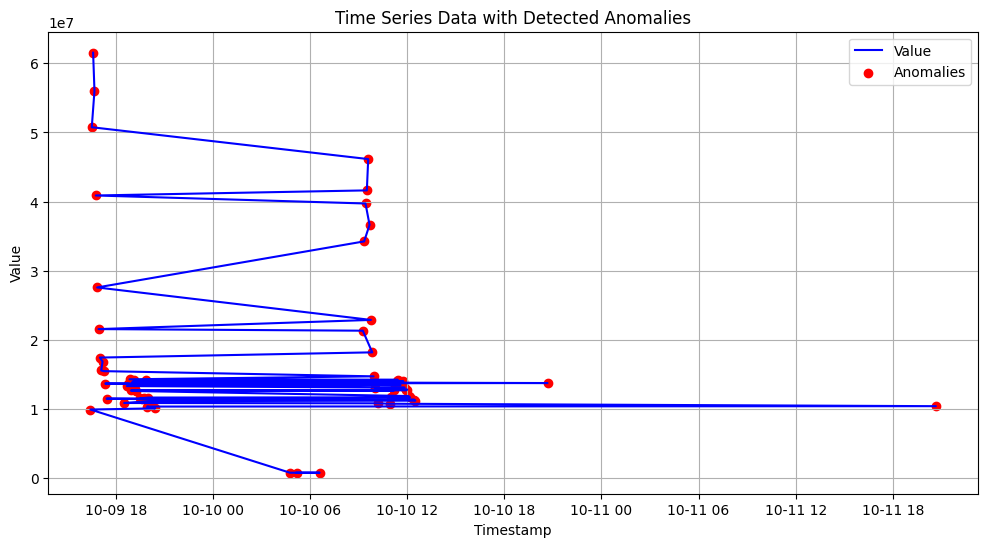

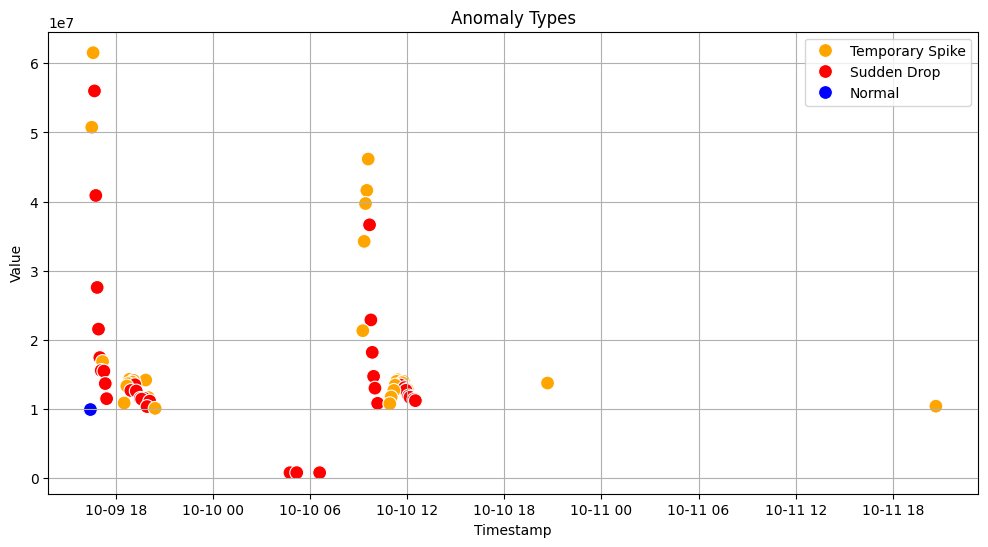

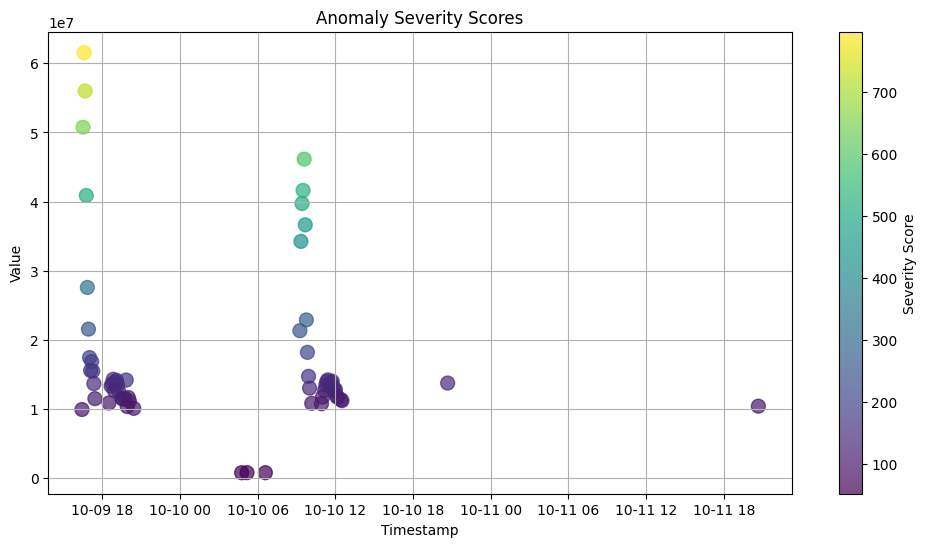

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

<ipython-input-106-92af0c62b712>:16: RuntimeWarning:

divide by zero encountered in scalar divide



10


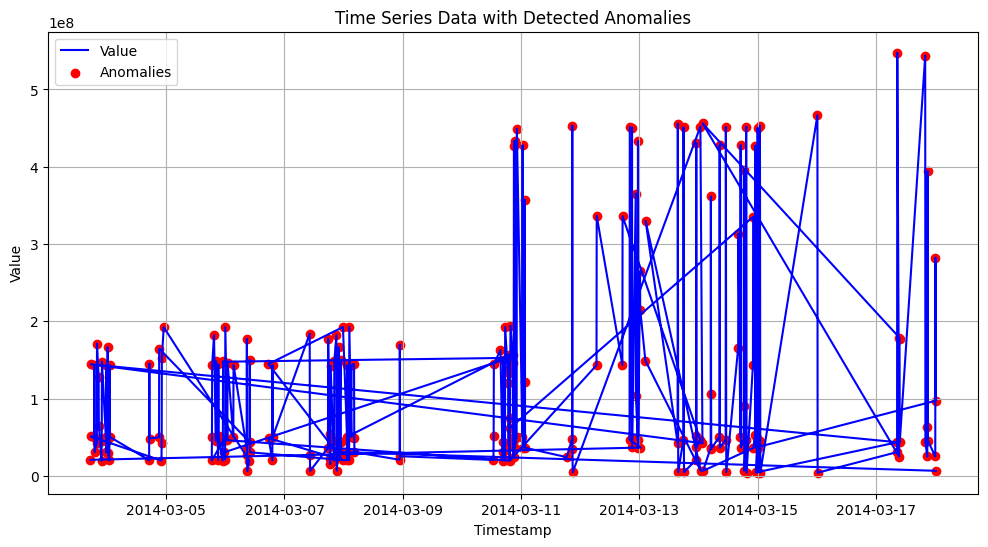

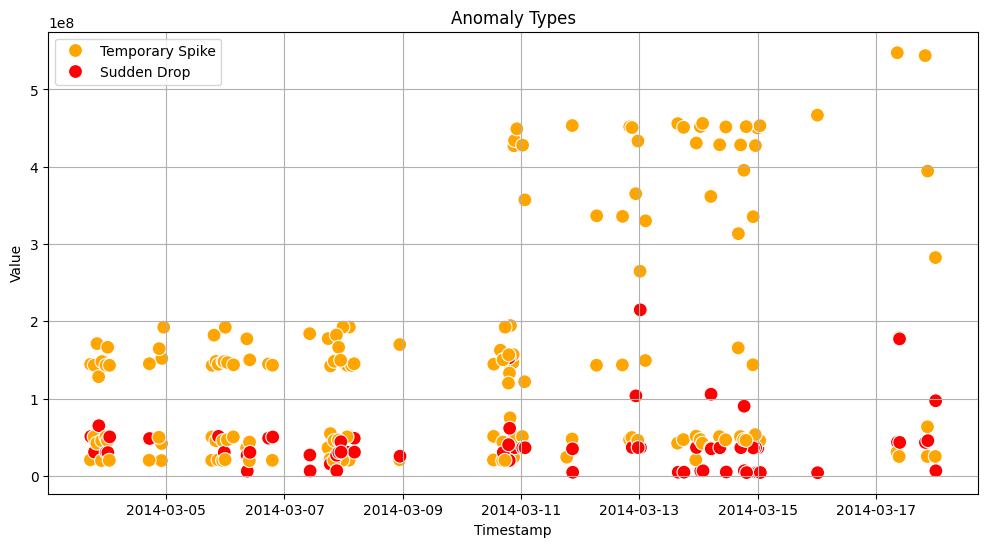

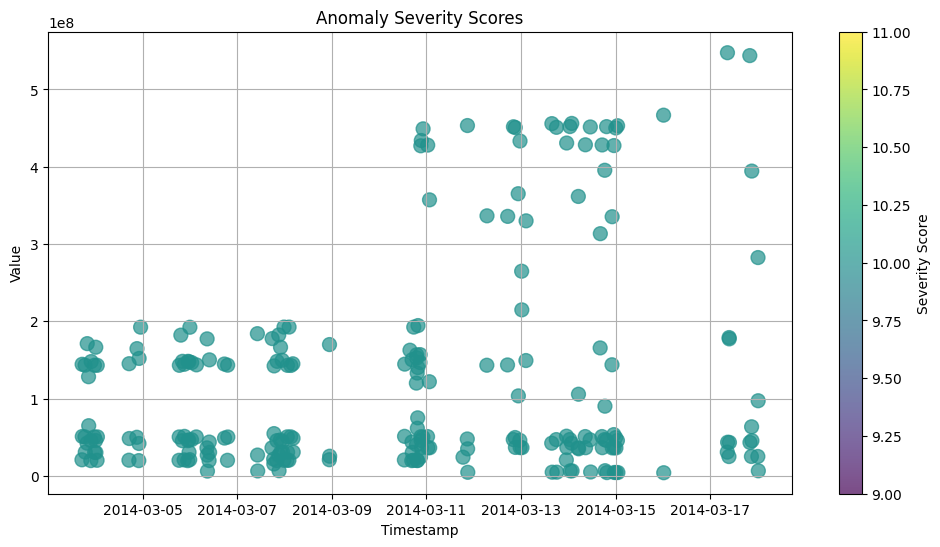

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



11


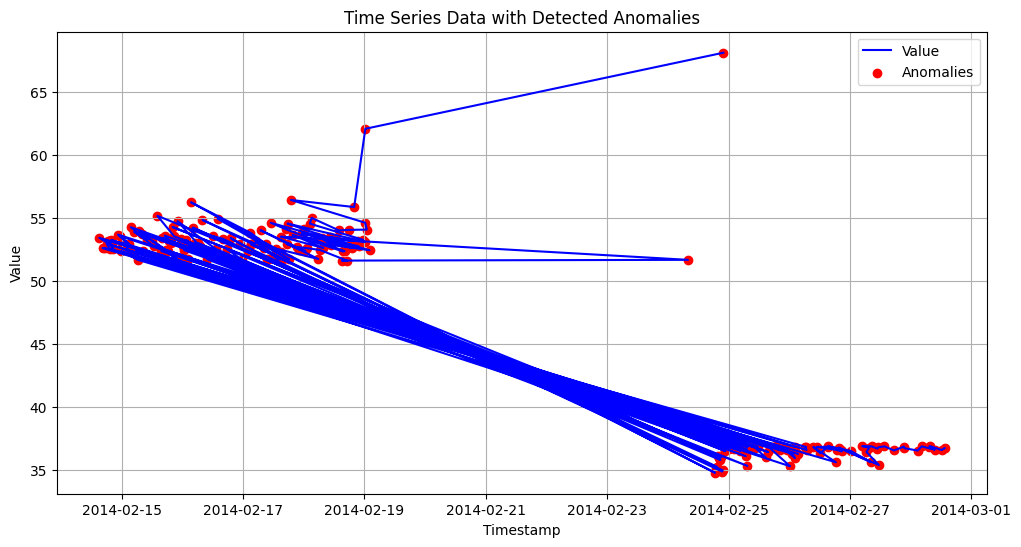

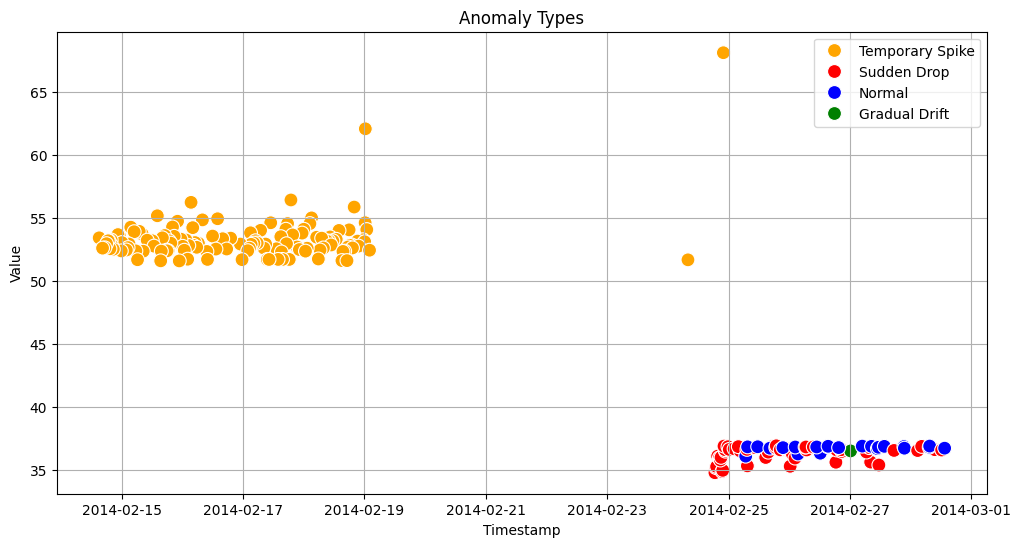

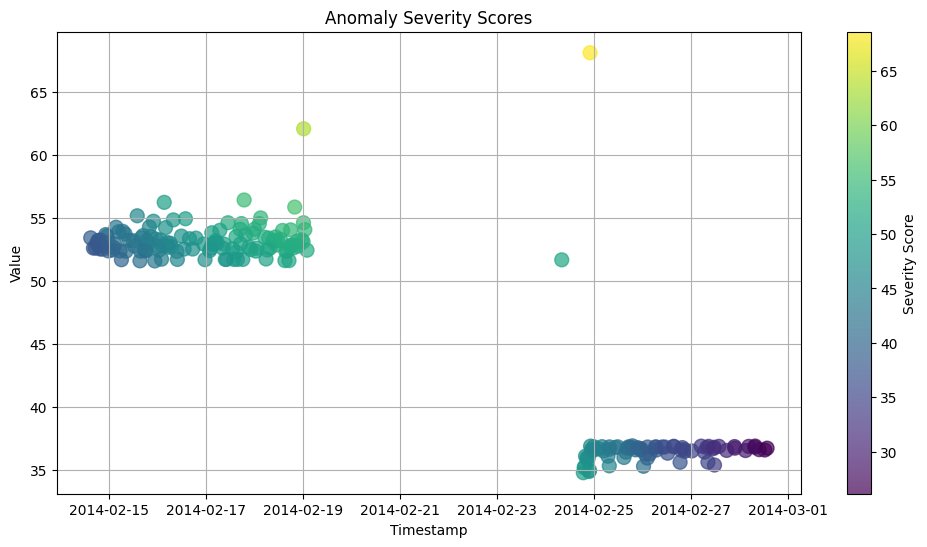

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



12


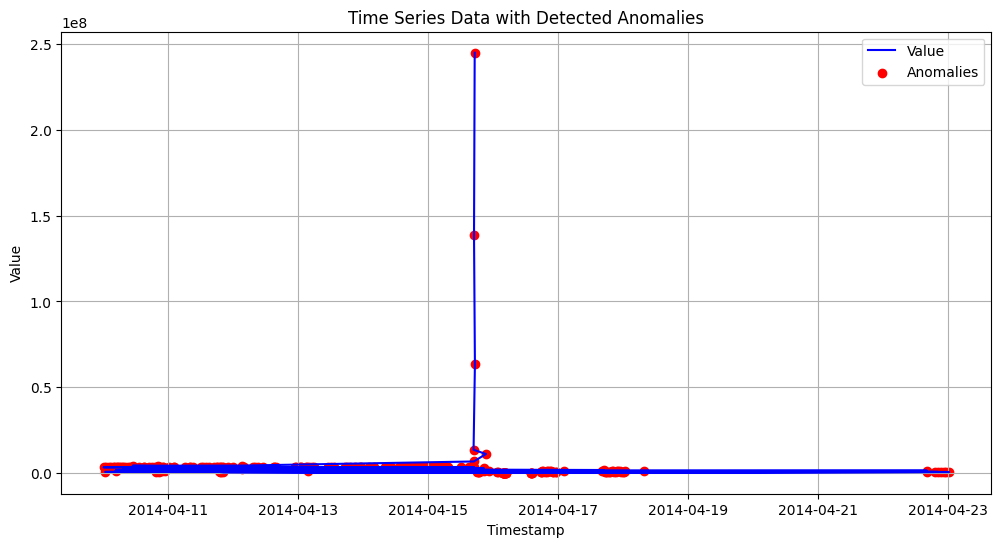

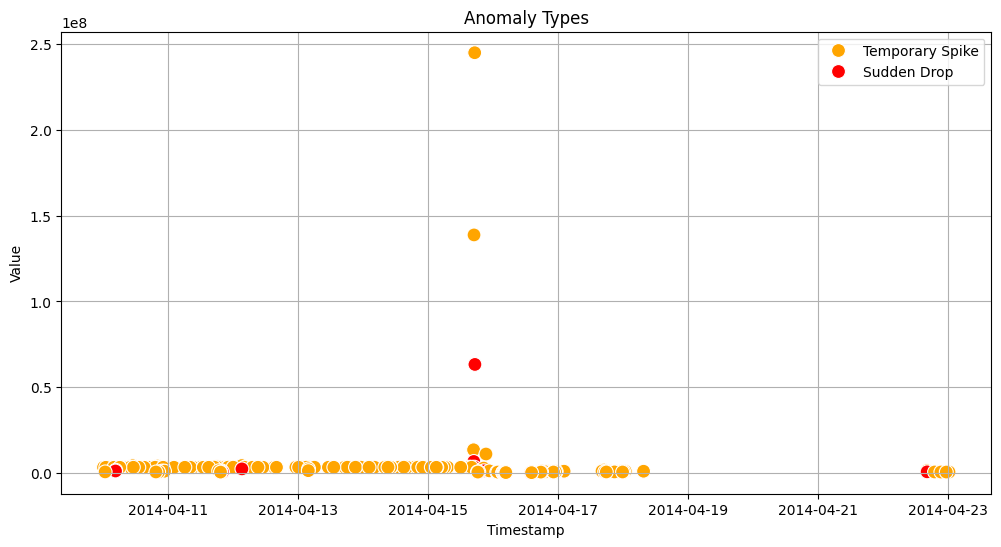

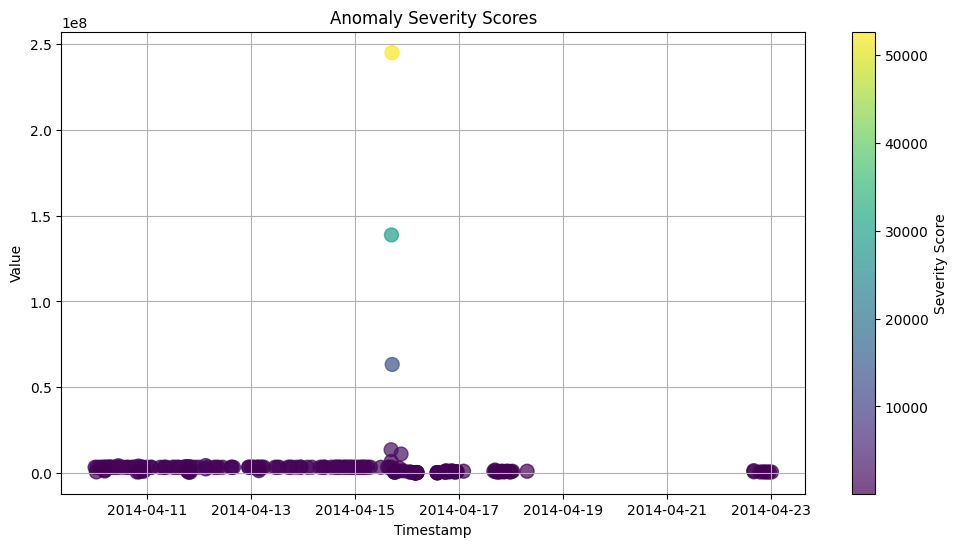

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



13


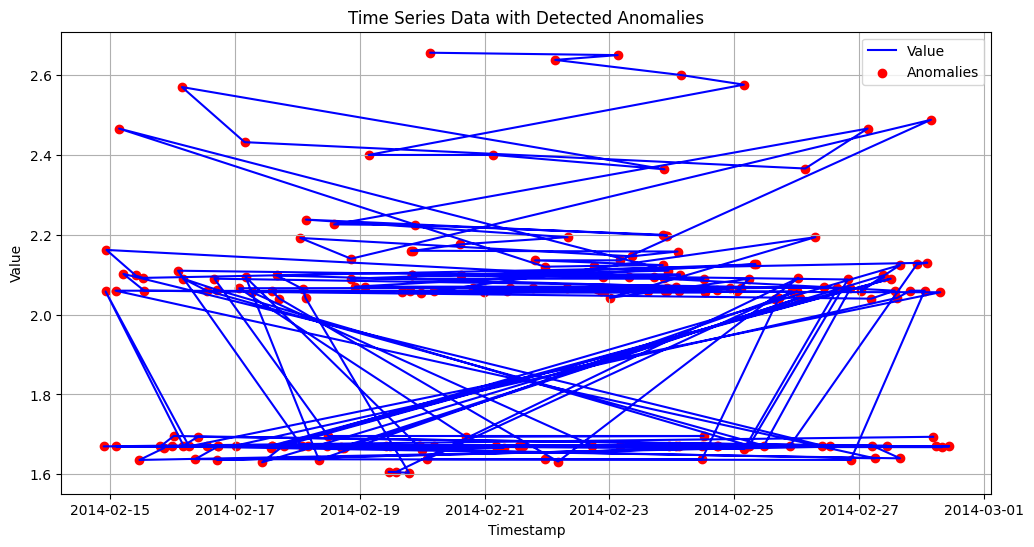

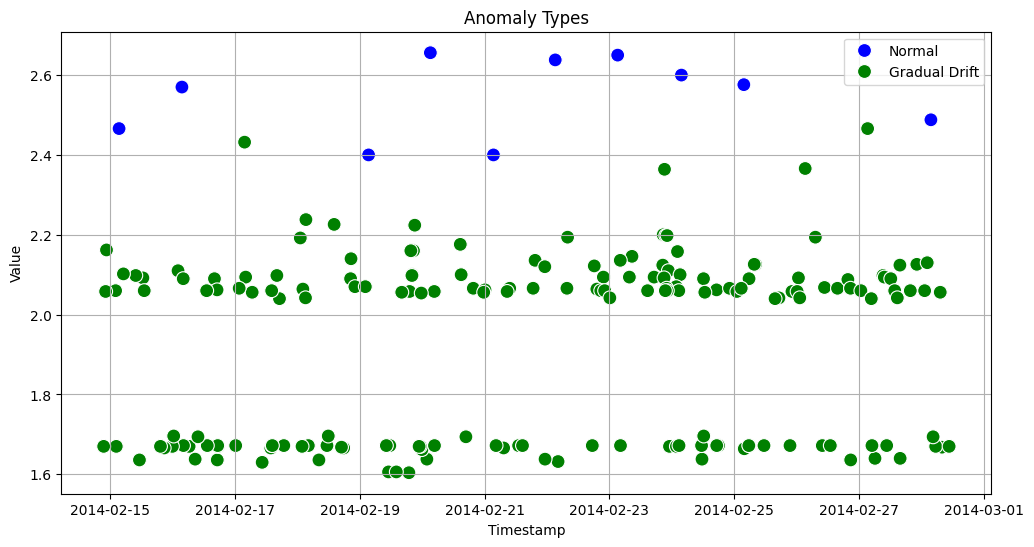

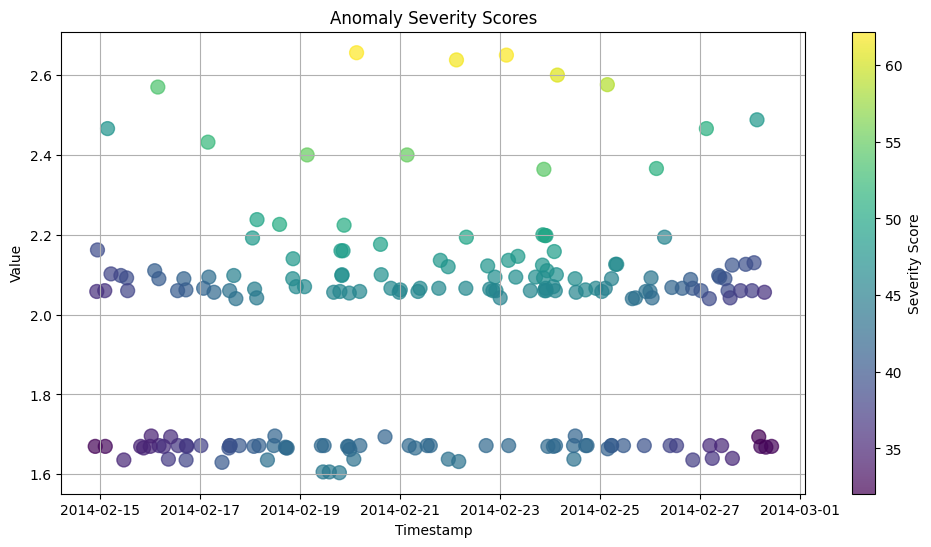

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



14


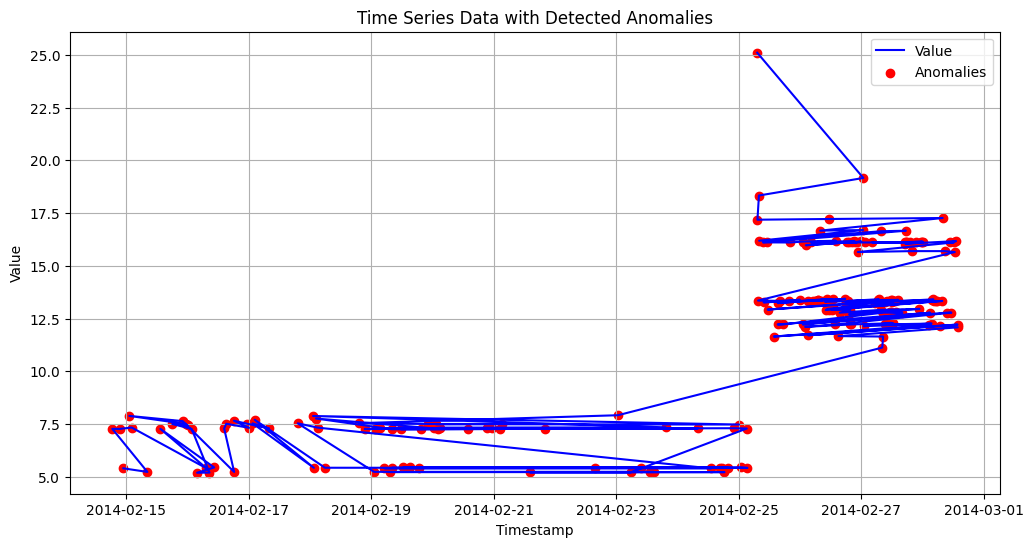

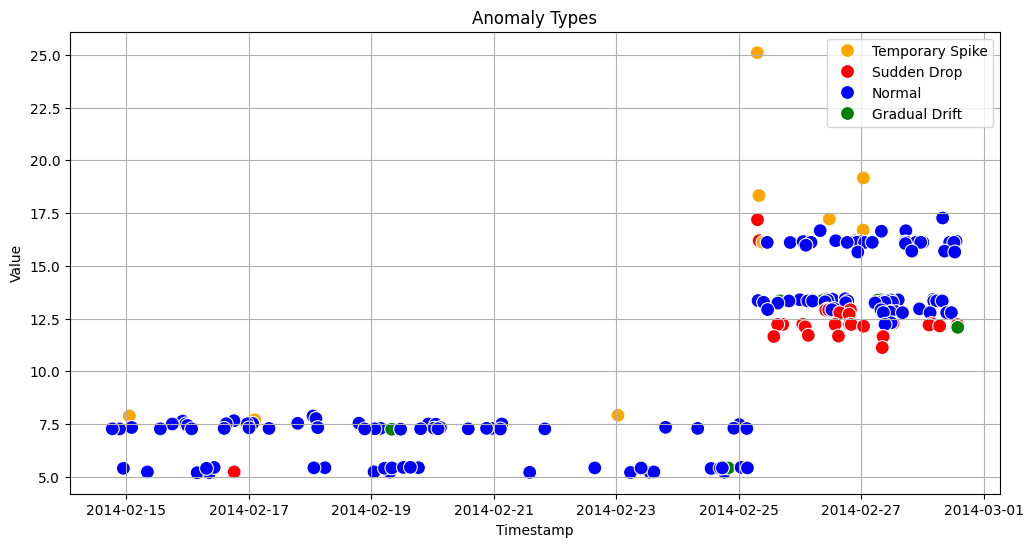

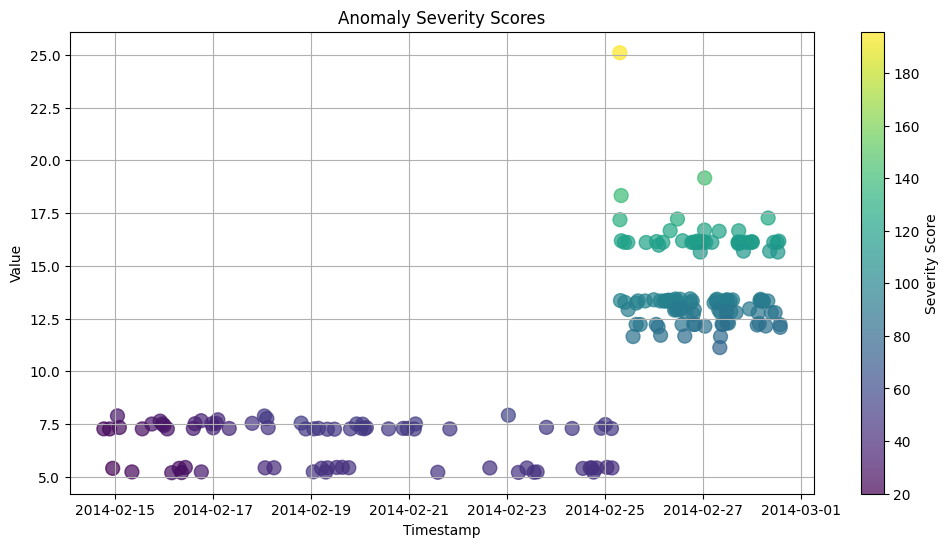

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



15


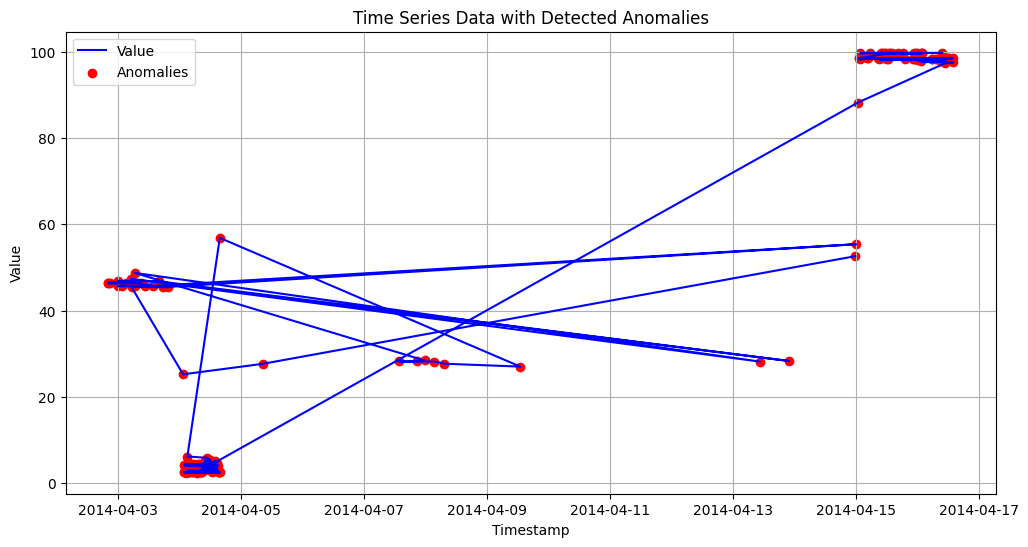

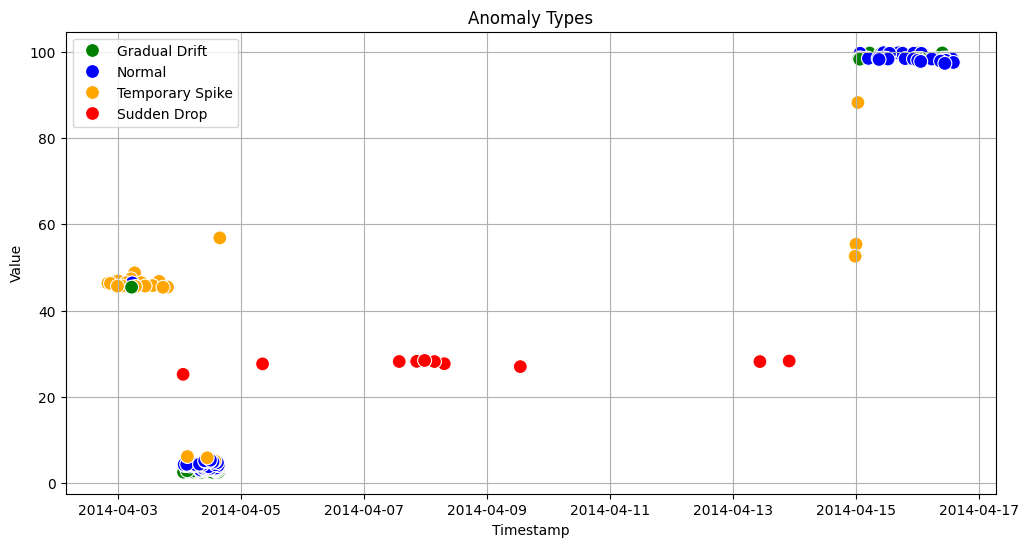

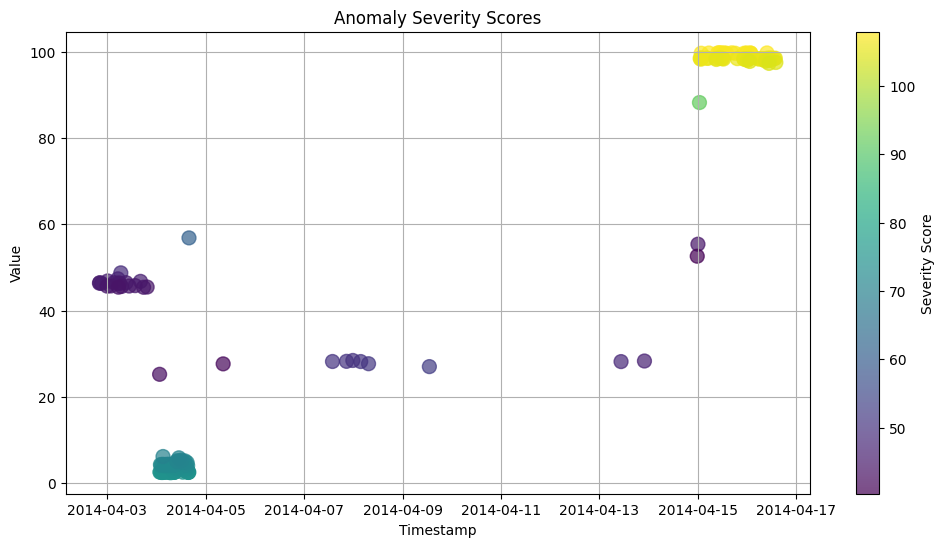

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



16


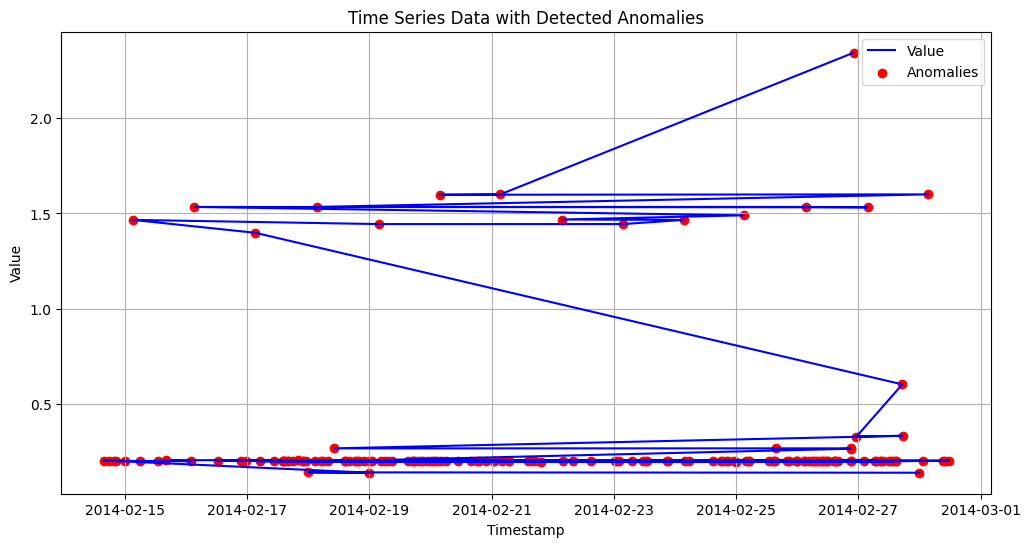

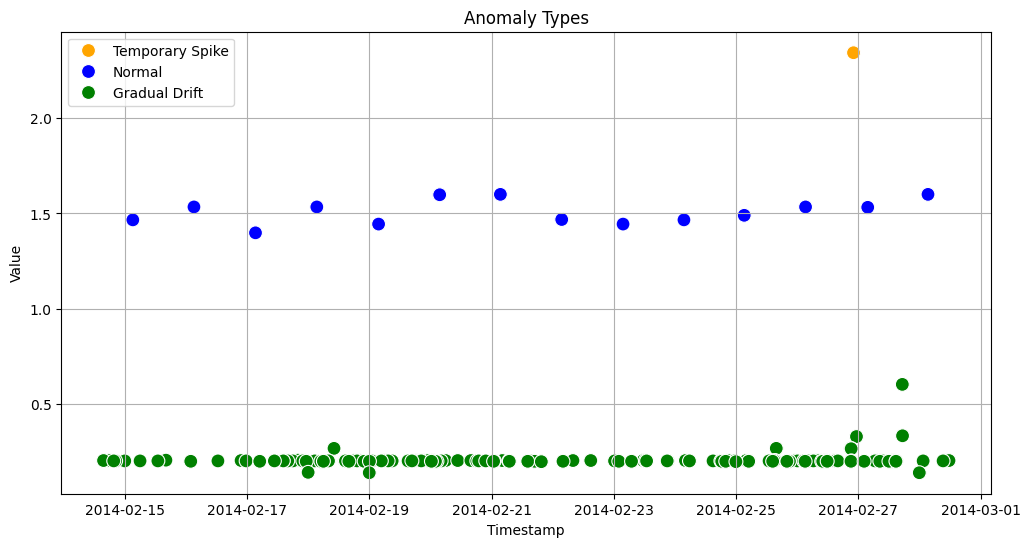

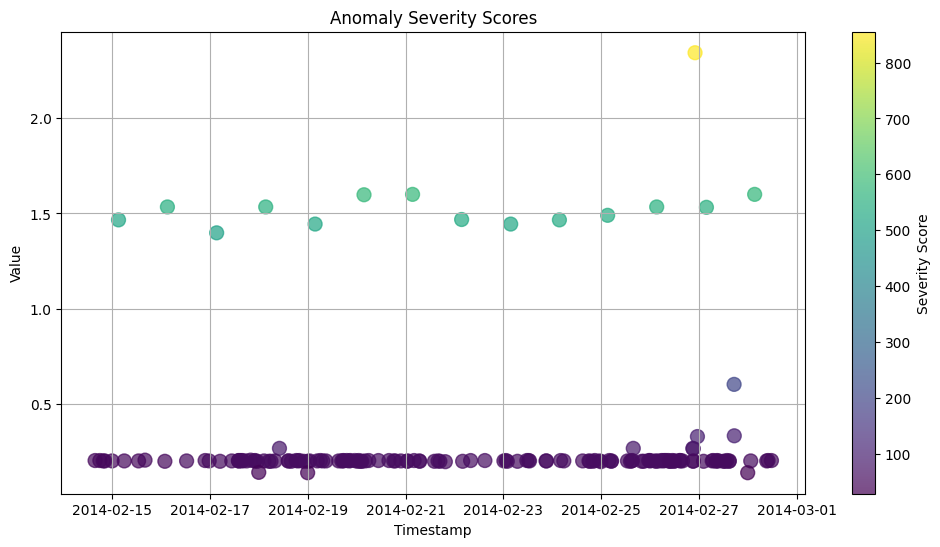

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<ipython-input-106-92af0c62b712>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



17


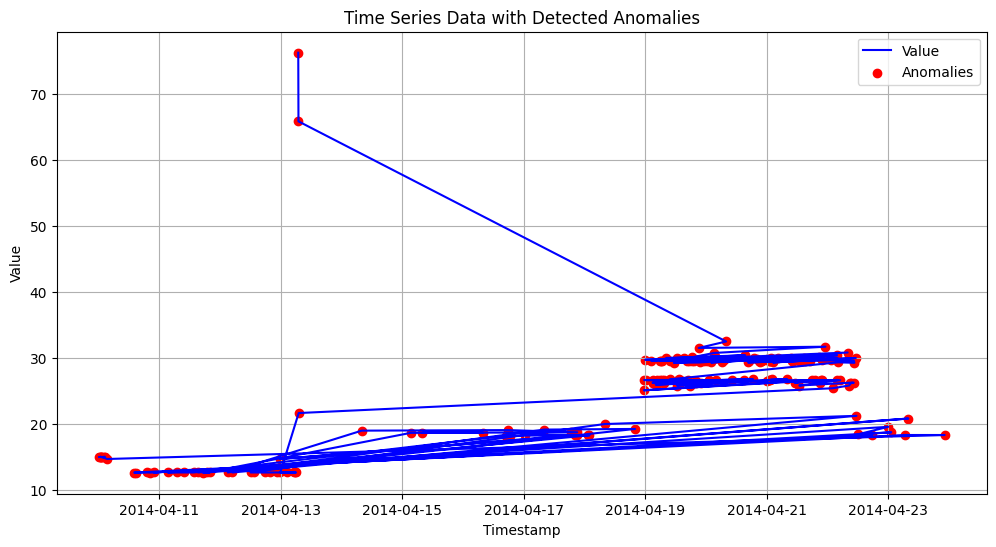

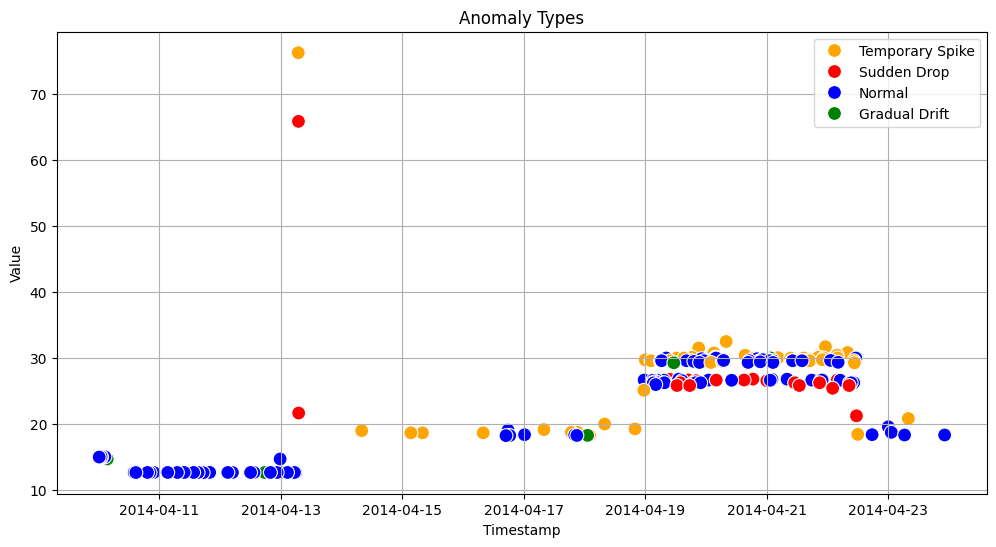

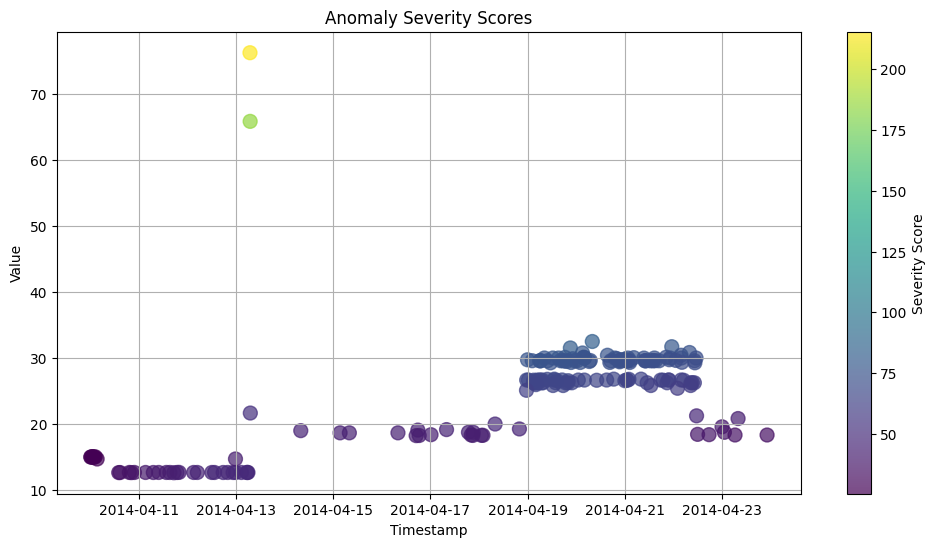

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
for i in range(1,18):
  data = pd.read_csv("/content/drive/MyDrive/computing-usage-dataset/"+str(i)+".csv", parse_dates=['timestamp'], index_col='timestamp')
  data = anomaly(data)

  # Check if data is not empty before plotting
  if not data.empty:
    print(i)
    # Line Plot of Time Series Data
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['value'], label='Value', color='blue')
    plt.scatter(data.index[data['anomaly'] == -1], data['value'][data['anomaly'] == -1], color='red', label='Anomalies')
    plt.title('Time Series Data with Detected Anomalies')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Anomaly Type Visualization
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=data, x=data.index, y='value', hue='anomaly_type', palette={'Normal': 'blue','Temporary Spike': 'orange', 'Gradual Drift': 'green', 'Sudden Drop': 'red'}, s=100)
    plt.title('Anomaly Types')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    #Severity Score Visualization
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(data.index, data['value'], c=data['severity_score'], cmap='viridis', s=100, alpha=0.7)
    plt.colorbar(scatter, label='Severity Score')
    plt.title('Anomaly Severity Scores')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

    #Interactive Plot with Plotly
    fig = px.scatter(data_frame=data, x=data.index, y='value', color='anomaly_type', size='severity_score', color_discrete_map={'Temporary Spike': 'orange', 'Gradual Drift': 'green', 'Sudden Drop': 'red'})
    fig.update_layout(title='Interactive Anomaly Visualization', xaxis_title='Timestamp', yaxis_title='Value')
    fig.show()
  else:
    print(f"No anomalies detected for dataset {i}")